
=== GROUP 1: WGD2038 Lens POW: Position constrained (HST Image considerations) (Freed PWI) ===
Observed Flux Ratios: [0.86, 1.0, 0.79, 0.39]
Predicted Flux Ratios (Obs Pos): [0.8228342806627071, 1.0, 0.836499897899459, 0.400577644493132]
Predicted Flux Ratios (Pred Pos): [0.8333029474323914, 1.0, 0.8421958877747392, 0.4050035450217766]

=== GROUP 2: WGD2038 Lens POW (Shear): Position constrained (HST Image considerations) (Freed PWI) ===
Observed Flux Ratios: [0.86, 1.0, 0.79, 0.39]
Predicted Flux Ratios (Obs Pos): [0.8201348880814018, 1.0, 0.8863706520977334, 0.41415583640106995]
Predicted Flux Ratios (Pred Pos): [0.8218277570110667, 1.0, 0.878708085513838, 0.4190619993739297]


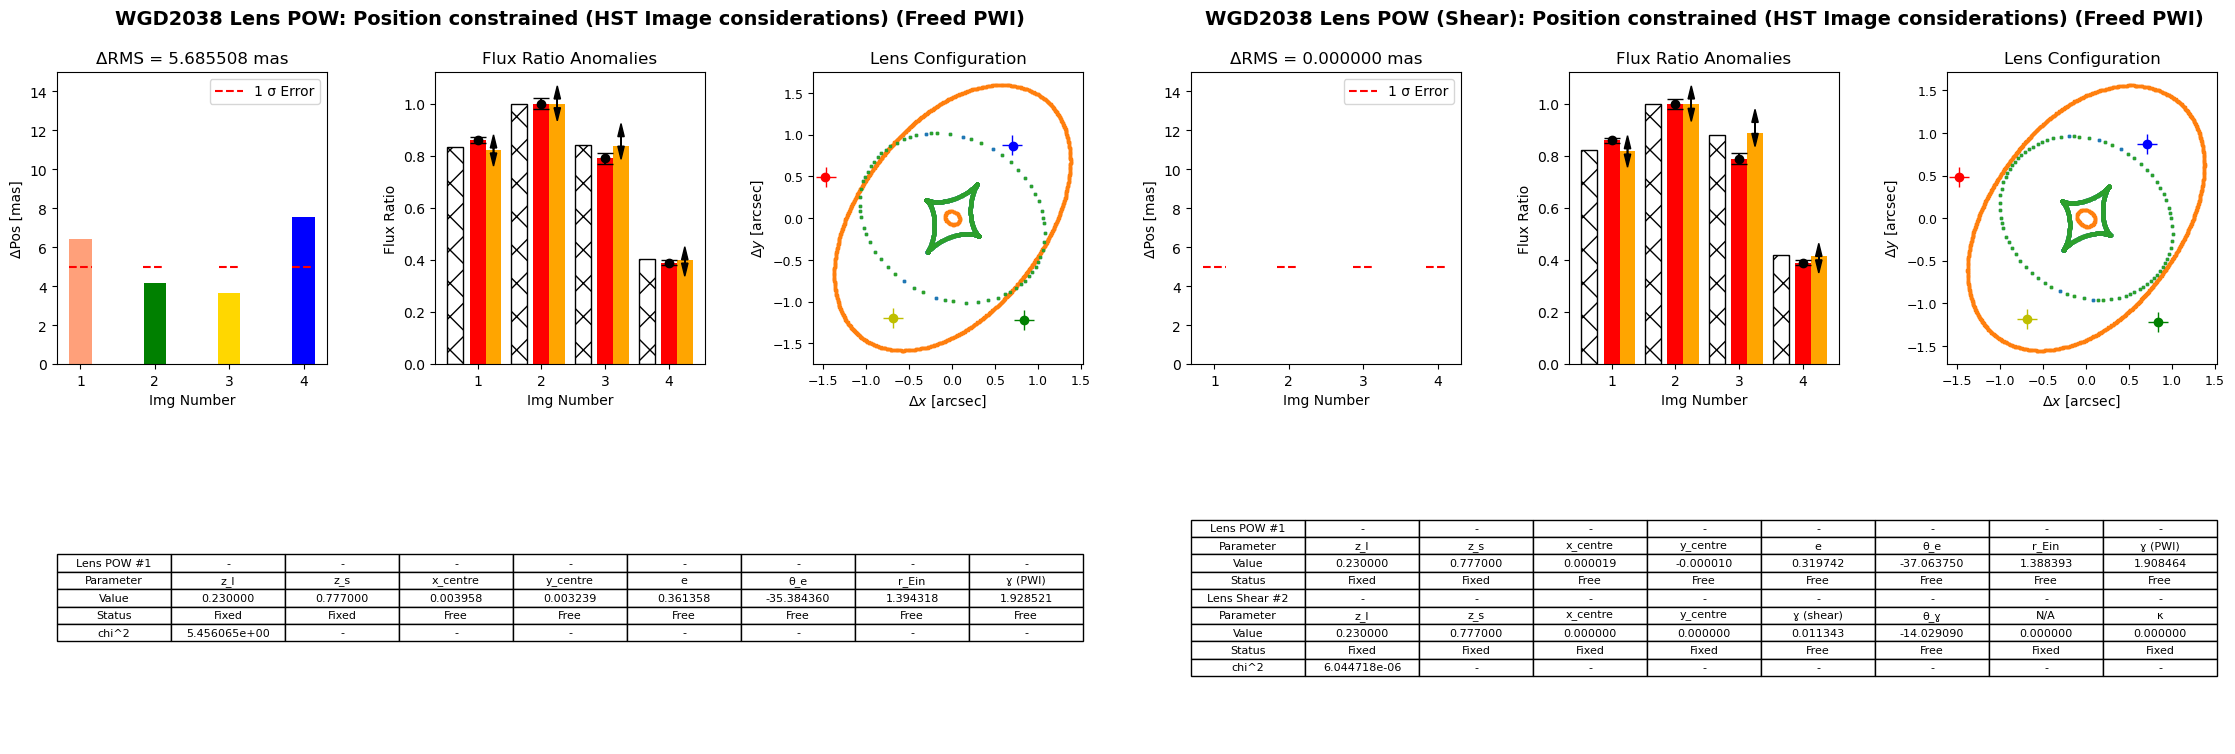

In [34]:
# Working Plotting Code that outputs lens anomaly results with all the necessary information as well as lens parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import math
import matplotlib.table as tbl
from matplotlib.patches import Rectangle

# Define groups of file paths

file_groups = [
    {
        "input_file": "WGD2038/obs_point_SIE(POS+FLUX).dat",
        "output_file": "WGD2038/PPC/outPP_N_Free_PWI_Free_PA_point.dat",
        "fits_file": "WGD2038/PPC/outPP_N_Free_PWI_Free_PA_lens.fits",
        "Critical_Curve": "WGD2038/PPC/outPP_N_Free_PWI_Free_PA_crit.dat",
        "optresult_file": "WGD2038/PPC/outPP_N_Free_PWI_Free_PA_optresult.dat",
        "title": "WGD2038 Lens POW: Position constrained (HST Image considerations) (Freed PWI)"
     },
    {
        "input_file": "WGD2038/obs_point_SIE(POS+FLUX).dat",
        "output_file": "WGD2038/PPC/outPPR_N_Free_PWI_Free_PA_point.dat",
        "fits_file": "WGD2038/PPC/outPPR_N_Free_PWI_Free_PA_lens.fits",
        "Critical_Curve": "WGD2038/PPC/outPPR_N_Free_PWI_Free_PA_crit.dat",
        "optresult_file": "WGD2038/PPC/outPPR_N_Free_PWI_Free_PA_optresult.dat",
        "title": "WGD2038 Lens POW (Shear): Position constrained (HST Image considerations) (Freed PWI)"
     },
]

n = 0.01

# Function to extract lens data from optresult file
def extract_lens_data(file_path):
    lens_data = []  # Will store tuples of (lens_type, data)
    chi2_value = None

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Warning: Could not find optresult file: {file_path}")
        return [], None

    # Step 1: Find the last occurrence of chi^2 in the file
    last_chi2_idx = None
    for idx, line in enumerate(lines):
        if line.strip().startswith("chi^2"):
            last_chi2_idx = idx

    if last_chi2_idx is None:
        print(f"Warning: No chi^2 section found in the file: {file_path}")
        return [], None

    # Step 2: Collect all lens profiles after the last chi^2
    for line in lines[last_chi2_idx:]:
        if line.strip().startswith("chi^2"):
            chi2_value = line.strip().split()[2]
        elif line.strip().startswith("lens   sie"):
            lens_data.append(('SIE', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pow"):
            lens_data.append(('POW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   anfw"):
            lens_data.append(('NFW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pert"):
            lens_data.append(('Shear', line.strip().split()[2:]))
        elif line.strip().startswith("lens   sers"):
            lens_data.append(('SERSIC', line.strip().split()[2:]))

    return lens_data, chi2_value

# Function to create parameter table
def create_parameter_table(lens_data, chi2_value):
    if not lens_data:
        return None
    
    # Prepare table data for all found profiles
    table_data = []
    for idx, (lens_type, data) in enumerate(lens_data, 1):
        data = [float(val) for val in data]
        data = [f"{val:.6e}" if abs(val) > 10000 else f"{val:.6f}" for val in data]

        if lens_type == "SIE":
            labels = ["z_l", "vel. disp.", "x_centre", "y_centre", "e", "θ_e", "r_core", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens SIE #{idx}"
        elif lens_type == "POW":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "e", "θ_e", "r_Ein", "ɣ (PWI)"]
            status = ["Fixed", "Fixed", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens POW #{idx}"
        elif lens_type == "NFW":
            labels = ["z_l", "M_DM", "x_centre", "y_centre", "e", "θ_e", "c", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Fixed"]
            header = f"Lens NFW #{idx}"
        elif lens_type == "Shear":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "ɣ (shear)", "θ_ɣ", "N/A", "κ"]
            status = ["Fixed", "Fixed", "Fixed", "Fixed", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens Shear #{idx}"
        elif lens_type == "SERSIC":
            labels = ["z_l", "M_BM", "x_centre", "y_centre", "e", "θ_e", "r_e", "n"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens SERSIC #{idx}"
        else:
            continue

        table_data.append([header, "-", "-", "-", "-", "-", "-", "-", "-"])
        table_data.append(["Parameter"] + labels)
        table_data.append(["Value"] + data)
        table_data.append(["Status"] + status)

    if chi2_value:
        table_data.append(["chi^2", chi2_value, "-", "-", "-", "-", "-", "-", "-"])

    return table_data

# Function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Function to read observed positions, flux ratio errors, and observed flux ratios
def read_observed_positions(input_file):
    observed_positions = []
    flux_ratio_errors = []
    observed_flux_ratios = []
    with open(input_file, 'r') as observed_file:
        observed_lines = observed_file.readlines()[1:]  # Skip the first line
        for line in observed_lines:
            columns = line.split()
            if len(columns) >= 5:
                x1 = float(columns[0])
                y1 = float(columns[1])
                flux_ratio = float(columns[2])  # Extract flux ratio from the third column
                observed_positions.append((x1, y1))
                flux_ratio_errors.append(float(columns[4]))  # Extract flux ratio error
                observed_flux_ratios.append(flux_ratio)
    return observed_positions, flux_ratio_errors, observed_flux_ratios

# Function to read predicted positions and magnifications
def read_predicted_positions(output_file):
    predicted_positions = []
    predicted_magnifications = []
    with open(output_file, 'r') as predicted_file:
        predicted_lines = predicted_file.readlines()[1:]  # Skip the first line
        for line in predicted_lines:
            if line.startswith("#"):
                continue  # Skip comment lines
            columns = line.split()
            if len(columns) >= 3:
                x2 = float(columns[0])
                y2 = float(columns[1])
                M2 = abs(float(columns[2]))  # Take the absolute value of the magnification
                predicted_positions.append((x2, y2))
                predicted_magnifications.append(M2)
    return predicted_positions, predicted_magnifications

# Function to pair predicted and observed positions
def pair_positions(observed_positions, predicted_positions, predicted_magnifications):
    paired_positions = []
    for observed_position in observed_positions:
        min_distance = float('inf')
        closest_index = None
        for i, predicted_position in enumerate(predicted_positions):
            distance = calculate_distance(*observed_position, *predicted_position)
            if distance < min_distance:
                min_distance = distance
                closest_index = i
        paired_positions.append((observed_position, predicted_positions[closest_index], predicted_magnifications[closest_index]))
    return paired_positions

Dependent_image = 1 ###### --------------- Select image to be dependent -------------------------------------------------------------------------------------------------------------

# Function to process the FITS file for observed values
def process_fits_file(fits_file, observed_positions, green_image_index= Dependent_image):
    with fits.open(fits_file) as hdul:
        Mag = hdul[0].data[6]
        
        image_size = Mag.shape
        center_x = image_size[1] // 2
        center_y = image_size[0] // 2
        pixel_coords = [(int((x + center_x * n) / n), int((y + center_y * n) / n)) for x, y in observed_positions]
        
        values = [Mag[y, x] for x, y in pixel_coords]
        abs_values = [1 / abs(value) for value in values]
        return abs_values, pixel_coords, image_size, Mag

# Function to calculate flux ratios and magnifications within error bounds
def calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag, green_image_index= Dependent_image):
    # Calculate flux ratios
    normalization_value = predicted_magnifications_ordered[green_image_index]
    predicted_flux_ratios = [magnification / normalization_value for magnification in predicted_magnifications_ordered]

    # Calculate flux ratios at the observed position 
    predicted_flux_ratios_observed = [abs_values[i] / abs_values[green_image_index] for i in range(len(abs_values))]
    
    # Calculate the circular range for each position
    error = 0.005
    value_ranges = []
    for x, y in pixel_coords:
        x_min = int(max(0, x - error / n))
        x_max = int(min(image_size[1] - 1, x + error / n))
        y_min = int(max(0, y - error / n))
        y_max = int(min(image_size[0] - 1, y + error / n))
        value_range = Mag[y_min : y_max + 1, x_min : x_max + 1]
        value_ranges.append(value_range)
    
    # Find the maximum and minimum values within each circular range
    max_values = [1 / np.min(np.abs(range_vals)) for range_vals in value_ranges]
    min_values = [1 / np.max(np.abs(range_vals)) for range_vals in value_ranges]
    
    # Automatically use the green_image_index position for normalization
    normalization_coord = pixel_coords[green_image_index]
    index = pixel_coords.index(normalization_coord)
    
    # Divide the base value by all other values
    divided_values = [abs_value / abs_values[index] for abs_value in abs_values]
    max_values = [max_value / abs_values[index] for max_value in max_values]
    min_values = [min_value / abs_values[index] for min_value in min_values]
    
    return predicted_flux_ratios, predicted_flux_ratios_observed, list(zip(min_values, max_values))

# Function to process a single group
def process_group(group_files):
    input_file = group_files["input_file"]
    output_file = group_files["output_file"]
    fits_file = group_files["fits_file"]
    Critical_Curve = group_files["Critical_Curve"]
    optresult_file = group_files["optresult_file"]  # Added this line
    
    # Read observed and predicted data
    observed_positions, flux_ratio_errors, observed_flux_ratios = read_observed_positions(input_file)
    predicted_positions, predicted_magnifications = read_predicted_positions(output_file)
    
    # Extract lens data for parameter table
    lens_data, chi2_value = extract_lens_data(optresult_file)
    table_data = create_parameter_table(lens_data, chi2_value)
    
    # Pair observed and predicted positions based on closeness
    paired_positions = []
    for i, observed_position in enumerate(observed_positions):
        min_distance = float('inf')
        closest_predicted = None
        for predicted_position in predicted_positions:
            distance = abs(observed_position[0] - predicted_position[0]) + abs(observed_position[1] - predicted_position[1])
            if distance < min_distance:
                min_distance = distance
                closest_predicted = predicted_position
        paired_positions.append((observed_position, closest_predicted))

    # Define pair names
    pair_names = ["Red Image", "Green Image", "Yellow Image", "Blue Image"]
        
    # Populate image_coordinates dictionary
    image_coordinates = {}
    for i, pair in enumerate(paired_positions):
        image_coordinates[pair_names[i]] = (*pair[0], *pair[1])

    # Calculate the distances and ΔRMS
    distances = []
    squared_distances = 0.0  # Initialize the sum of squared distances

    for image, coordinates in image_coordinates.items():
        x1, y1, x2, y2 = coordinates
        distance = calculate_distance(x1, y1, x2, y2)
        distances.append(distance)
        squared_distances += distance ** 2  # Sum the squared distances

    mean_squared_distances = squared_distances / len(image_coordinates)  # Calculate the mean of squared distances
    delta_rms = np.sqrt(mean_squared_distances)  # Calculate the root mean square

    # Convert distances to milliarc seconds for plotting
    distances_mas = [d * 1000 for d in distances]  # Convert from arcsec to milliarcsec
    delta_rms_mas = delta_rms * 1000  # Convert ΔRMS to milliarcsec

    # Pair positions
    paired_positions_detailed = pair_positions(observed_positions, predicted_positions, predicted_magnifications)

    # Order predicted positions and magnifications
    predicted_positions_ordered = [pair[1] for pair in paired_positions_detailed]
    predicted_magnifications_ordered = [pair[2] for pair in paired_positions_detailed]

    # Process FITS file
    abs_values, pixel_coords, image_size, Mag = process_fits_file(fits_file, observed_positions)

    # Calculate flux ratios and min/max magnifications
    predicted_flux_ratios, predicted_flux_ratios_observed, min_max_magnifications = calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag)

    # Read critical curve data
    caus = pd.read_csv(Critical_Curve, sep='\s+', header=None)
    caus = pd.DataFrame(caus)

    return {
        'distances_mas': distances_mas,
        'delta_rms_mas': delta_rms_mas,
        'observed_flux_ratios': observed_flux_ratios,
        'flux_ratio_errors': flux_ratio_errors,
        'predicted_flux_ratios': predicted_flux_ratios,
        'predicted_flux_ratios_observed': predicted_flux_ratios_observed,
        'min_max_magnifications': min_max_magnifications,
        'paired_positions_detailed': paired_positions_detailed,
        'pair_names': pair_names,
        'caus': caus,
        'table_data': table_data,  # Added this line
        'title': group_files["title"]
    }

# Function to plot a single group with parameter table
def plot_group(group_data, axs_group, colors, table_ax=None):
    distances_mas = group_data['distances_mas']
    delta_rms_mas = group_data['delta_rms_mas']
    observed_flux_ratios = group_data['observed_flux_ratios']
    flux_ratio_errors = group_data['flux_ratio_errors']
    predicted_flux_ratios = group_data['predicted_flux_ratios']
    predicted_flux_ratios_observed = group_data['predicted_flux_ratios_observed']
    min_max_magnifications = group_data['min_max_magnifications']
    paired_positions_detailed = group_data['paired_positions_detailed']
    pair_names = group_data['pair_names']
    caus = group_data['caus']
    table_data = group_data['table_data']
    
    # Plot 1: Positional offset
    x_positions = [1, 2, 3, 4]
    axs_group[0].bar(x_positions, distances_mas, color=colors, width=0.3)
    axs_group[0].axhline(y=5, xmin=0.045, xmax=0.13, color='r', linestyle='dashed', label="1 σ Error")
    axs_group[0].axhline(y=5, xmin=0.32, xmax=0.4, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.6, xmax=0.68, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.87, xmax=0.95, color='r', linestyle='dashed')
    axs_group[0].set_xlabel("Img Number")
    axs_group[0].set_ylabel("ΔPos [mas]")
    axs_group[0].set_title(f"ΔRMS = {delta_rms_mas:.6f} mas")

    # Ensure y-axis always starts from 0
    max_distance_mas = max(distances_mas) if distances_mas else 10
    y_max = max(max_distance_mas * 1.1, 15)
    axs_group[0].set_ylim(0, y_max)

    axs_group[0].set_xticks(x_positions)
    axs_group[0].set_xticklabels([1, 2, 3, 4])
    axs_group[0].legend()

    # Plot 2: Flux ratios
    barWidth = 0.25
    br1 = np.arange(len(observed_flux_ratios))
    br2 = [x + barWidth for x in br1]
    br3 = [x + 2 * barWidth for x in br1]
    br1, br2 = br2, br1

    axs_group[1].bar(br1, observed_flux_ratios, color='red', width=barWidth, label='μ_obs/μ_ref')
    axs_group[1].bar(br2-0.1, predicted_flux_ratios, color='white', edgecolor='black', hatch='\\/', width=barWidth, label='μ_pred/μ_ref')
    axs_group[1].bar(br3, predicted_flux_ratios_observed, color='orange', width=barWidth, label='µ_pred/μ_ref (obs pos)')
    
    axs_group[1].set_xlabel('Img Number', fontsize=10)
    axs_group[1].set_ylabel('Flux Ratio', fontsize=10)
    axs_group[1].set_xticks([r + barWidth for r in range(len(observed_flux_ratios))])
    axs_group[1].set_xticklabels([1, 2, 3, 4], fontsize=10)
    axs_group[1].set_title("Flux Ratio Anomalies", fontsize=12)

    # Add error bars for observed flux ratios
    axs_group[1].errorbar(br1, observed_flux_ratios, yerr=flux_ratio_errors, fmt='o', color='black', capsize=6, label='1 σ Error')

    # Creating magnification arrows with correct min and max values
    for x, (min_val, max_val) in zip(br3, min_max_magnifications):
        arrow_length = max_val - min_val
        # Draw arrow from min_val to max_val
        axs_group[1].arrow(x, min_val, 0, arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')
        axs_group[1].arrow(x, max_val, 0, -arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')

    # Plot 3: Lens configuration
    x1, y1 = 0, 0

    def center_corr_arcsec(x, y):
        x0, y0 = x1, y1
        x_prime = x + x0
        y_prime = y + y0
        return x_prime, y_prime

    # Convert critical curves and caustics to arcseconds
    xs1, ys1 = center_corr_arcsec(caus[2], caus[3])
    xs2, ys2 = center_corr_arcsec(caus[6], caus[7])
    xc1, yc1 = center_corr_arcsec(caus[0], caus[1])
    xc2, yc2 = center_corr_arcsec(caus[4], caus[5])

    axs_group[2].scatter(xs1, ys1, marker=',', s=1, label='Caustics')
    axs_group[2].scatter(xc1, yc1, marker=',', s=1, label='Crit Curve')
    axs_group[2].scatter(xs2, ys2, marker=',', s=1, label='Caustics')
    axs_group[2].set_xlabel('Δ$x$ [arcsec]', fontsize=10)
    axs_group[2].set_ylabel('Δ$y$ [arcsec]', fontsize=10)
    axs_group[2].set_title("Lens Configuration", fontsize=12)

    # Plot predicted and observed positions
    for i in range(len(paired_positions_detailed)):
        pair_name = pair_names[i]
        observed_position = paired_positions_detailed[i][0]
        predicted_position = paired_positions_detailed[i][1]
        
        if pair_name == "Red Image":
            pred_color = 'r+'
            obs_color = 'r'
        elif pair_name == "Green Image":
            pred_color = 'g+'
            obs_color = 'g'
        elif pair_name == "Yellow Image":
            pred_color = 'y+'
            obs_color = 'y'
        elif pair_name == "Blue Image":
            pred_color = 'b+'
            obs_color = 'b'
        
        axs_group[2].plot(predicted_position[0], predicted_position[1], pred_color, markersize=15)
        axs_group[2].plot(observed_position[0] - x1, observed_position[1] - y1, obs_color, marker='o')

    axs_group[2].tick_params(axis='both', which='major', labelsize=9)
    
    # Add parameter table if table_ax is provided and table_data exists
    if table_ax is not None and table_data:
        table_ax.axis('off')
        table = tbl.table(table_ax, cellText=table_data, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.0)

# Main execution
num_groups = len(file_groups)
colors = ['lightsalmon', 'green', 'gold', 'blue']

# Process all groups
group_results = []
for group_files in file_groups:
    group_data = process_group(group_files)
    group_results.append(group_data)

# Handle plotting based on number of groups
if num_groups == 1:
    # Special case for single group - use original layout with table
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplot layout: 3 plots on top, table on bottom
    axs = [plt.subplot2grid((2, 3), (0, i)) for i in range(3)]
    table_ax = plt.subplot2grid((2, 3), (1, 0), colspan=3)
    
    # Plot the single group
    plot_group(group_results[0], axs, colors, table_ax)
    
    # Set the title to the group's specific title
    plt.suptitle(group_results[0]['title'], fontsize=16)
    plt.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.85, wspace=0.3, hspace=0.1)

else:
    # Multi-group layout: left, right, bottom-left, bottom-right pattern with tables
    rows = math.ceil(num_groups / 2) * 2  # Double the rows to accommodate tables
    cols = 2
    
    fig = plt.figure(figsize=(24, 8 * math.ceil(num_groups / 2)))
    
    for group_idx, group_data in enumerate(group_results):
        # Calculate position: left-right pattern, then move to next row
        row = (group_idx // 2) * 2  # Every two groups take 2 rows
        col = group_idx % 2
        
        # Create 3 subplots for this group using subplot2grid
        axs_group = []
        for plot_idx in range(3):
            ax = plt.subplot2grid((rows, 6), (row, col*3 + plot_idx))
            axs_group.append(ax)
        
        # Create table subplot below the plots
        table_ax = plt.subplot2grid((rows, 6), (row + 1, col*3), colspan=3)
        
        # Plot this group
        plot_group(group_data, axs_group, colors, table_ax)
        
        # Add group title above each group
        middle_ax = axs_group[1]  # Middle subplot of the 3-subplot group
        title_x = 0.5
        title_y = 1.15
        
        middle_ax.text(title_x, title_y, group_data['title'], 
                      ha='center', va='bottom', fontsize=14, weight='bold',
                      transform=middle_ax.transAxes)
    
    # Calculate hspace based on number of row pairs to maintain consistent spacing
    num_row_pairs = math.ceil(num_groups / 2)
    # Use a scaling factor that decreases as more rows are added
    hspace_value = 0.5 / num_row_pairs if num_row_pairs > 1 else 0.3
    
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.96, top=0.92, wspace=0.4, hspace=hspace_value)

# Print results for all groups
for group_idx, group_data in enumerate(group_results):
    print(f"\n=== GROUP {group_idx + 1}: {group_data['title']} ===")
    print("Observed Flux Ratios:", group_data['observed_flux_ratios'])
    print("Predicted Flux Ratios (Obs Pos):", group_data['predicted_flux_ratios_observed'])
    print("Predicted Flux Ratios (Pred Pos):", group_data['predicted_flux_ratios'])

# Save the plot
if num_groups == 1:
    # Use the group's title for filename when single group
    base_filename = group_results[0]['title'].replace(' ', '_').replace(':', '').replace('(', '').replace(')', '')
    file_name = f'{base_filename}.pdf'
else:
    file_name = 'WGD2038/Group_Plot_WGD2038_POW_Free_PWI.pdf'

if os.path.isfile(file_name):
    base_name, extension = os.path.splitext(file_name)
    counter = 1
    while os.path.isfile(f"{base_name} ({counter}){extension}"):
        counter += 1
    file_name = f"{base_name} ({counter}){extension}"

plt.savefig(file_name)
#plt.show()


=== GROUP 1: WFI2026 Lens POW: Position constrained (HST Image considerations) ===
Observed Flux Ratios: [1.0, 0.75, 0.31, 0.28]
Predicted Flux Ratios (Obs Pos): [1.0, 1.0134317350354005, 0.32604668051763236, 0.29685839412959414]
Predicted Flux Ratios (Pred Pos): [1.0, 0.7728687927076023, 0.2507511087796271, 0.28041394439410555]

=== GROUP 2: WFI2026 Lens POW (Shear): Position constrained (HST Image considerations) ===
Observed Flux Ratios: [1.0, 0.75, 0.31, 0.28]
Predicted Flux Ratios (Obs Pos): [1.0, 1.021987037997985, 0.32700996404798405, 0.2974568639803126]
Predicted Flux Ratios (Pred Pos): [1.0, 0.7729935160464229, 0.2507219528142538, 0.28030158557184115]


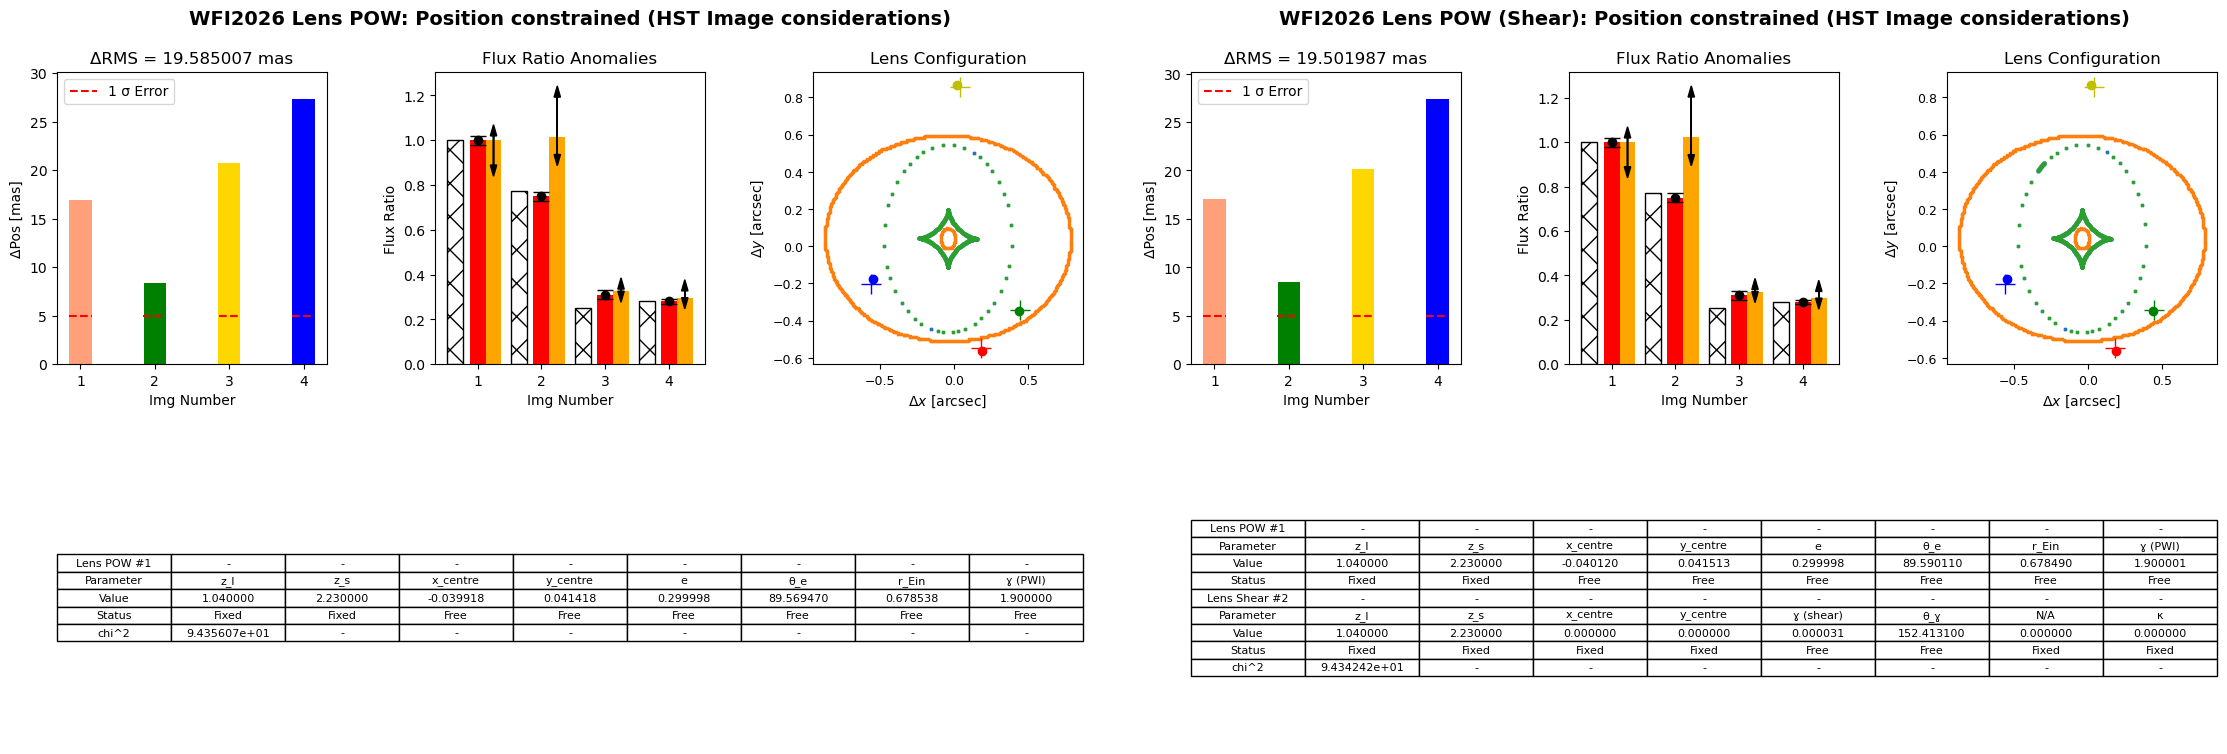

In [1]:
# Working Plotting Code that outputs lens anomaly results with all the necessary information as well as lens parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import math
import matplotlib.table as tbl
from matplotlib.patches import Rectangle

# Define groups of file paths

file_groups = [
    {
        "input_file": "WFI2026/PPFC/Wobs_point.dat",
        "output_file": "WFI2026/PPC/outPP_N_point.dat",
        "fits_file": "WFI2026/PPC/outPP_N_lens.fits",
        "Critical_Curve": "WFI2026/PPC/outPP_N_crit.dat",
        "optresult_file": "WFI2026/PPC/outPP_N_optresult.dat",
        "title": "WFI2026 Lens POW: Position constrained (HST Image considerations)"
     },
    {
        "input_file": "WFI2026/PPFC/Wobs_point.dat",
        "output_file": "WFI2026/PPC/outPPR_N_point.dat",
        "fits_file": "WFI2026/PPC/outPPR_N_lens.fits",
        "Critical_Curve": "WFI2026/PPC/outPPR_N_crit.dat",
        "optresult_file": "WFI2026/PPC/outPPR_N_optresult.dat",
        "title": "WFI2026 Lens POW (Shear): Position constrained (HST Image considerations)"
     },
]

n = 0.01

# Function to extract lens data from optresult file
def extract_lens_data(file_path):
    lens_data = []  # Will store tuples of (lens_type, data)
    chi2_value = None

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Warning: Could not find optresult file: {file_path}")
        return [], None

    # Step 1: Find the last occurrence of chi^2 in the file
    last_chi2_idx = None
    for idx, line in enumerate(lines):
        if line.strip().startswith("chi^2"):
            last_chi2_idx = idx

    if last_chi2_idx is None:
        print(f"Warning: No chi^2 section found in the file: {file_path}")
        return [], None

    # Step 2: Collect all lens profiles after the last chi^2
    for line in lines[last_chi2_idx:]:
        if line.strip().startswith("chi^2"):
            chi2_value = line.strip().split()[2]
        elif line.strip().startswith("lens   sie"):
            lens_data.append(('SIE', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pow"):
            lens_data.append(('POW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   anfw"):
            lens_data.append(('NFW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pert"):
            lens_data.append(('Shear', line.strip().split()[2:]))
        elif line.strip().startswith("lens   sers"):
            lens_data.append(('SERSIC', line.strip().split()[2:]))

    return lens_data, chi2_value

# Function to create parameter table
def create_parameter_table(lens_data, chi2_value):
    if not lens_data:
        return None
    
    # Prepare table data for all found profiles
    table_data = []
    for idx, (lens_type, data) in enumerate(lens_data, 1):
        data = [float(val) for val in data]
        data = [f"{val:.6e}" if abs(val) > 10000 else f"{val:.6f}" for val in data]

        if lens_type == "SIE":
            labels = ["z_l", "vel. disp.", "x_centre", "y_centre", "e", "θ_e", "r_core", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens SIE #{idx}"
        elif lens_type == "POW":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "e", "θ_e", "r_Ein", "ɣ (PWI)"]
            status = ["Fixed", "Fixed", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens POW #{idx}"
        elif lens_type == "NFW":
            labels = ["z_l", "M_DM", "x_centre", "y_centre", "e", "θ_e", "c", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Fixed"]
            header = f"Lens NFW #{idx}"
        elif lens_type == "Shear":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "ɣ (shear)", "θ_ɣ", "N/A", "κ"]
            status = ["Fixed", "Fixed", "Fixed", "Fixed", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens Shear #{idx}"
        elif lens_type == "SERSIC":
            labels = ["z_l", "M_BM", "x_centre", "y_centre", "e", "θ_e", "r_e", "n"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens SERSIC #{idx}"
        else:
            continue

        table_data.append([header, "-", "-", "-", "-", "-", "-", "-", "-"])
        table_data.append(["Parameter"] + labels)
        table_data.append(["Value"] + data)
        table_data.append(["Status"] + status)

    if chi2_value:
        table_data.append(["chi^2", chi2_value, "-", "-", "-", "-", "-", "-", "-"])

    return table_data

# Function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Function to read observed positions, flux ratio errors, and observed flux ratios
def read_observed_positions(input_file):
    observed_positions = []
    flux_ratio_errors = []
    observed_flux_ratios = []
    with open(input_file, 'r') as observed_file:
        observed_lines = observed_file.readlines()[1:]  # Skip the first line
        for line in observed_lines:
            columns = line.split()
            if len(columns) >= 5:
                x1 = float(columns[0])
                y1 = float(columns[1])
                flux_ratio = float(columns[2])  # Extract flux ratio from the third column
                observed_positions.append((x1, y1))
                flux_ratio_errors.append(float(columns[4]))  # Extract flux ratio error
                observed_flux_ratios.append(flux_ratio)
    return observed_positions, flux_ratio_errors, observed_flux_ratios

# Function to read predicted positions and magnifications
def read_predicted_positions(output_file):
    predicted_positions = []
    predicted_magnifications = []
    with open(output_file, 'r') as predicted_file:
        predicted_lines = predicted_file.readlines()[1:]  # Skip the first line
        for line in predicted_lines:
            if line.startswith("#"):
                continue  # Skip comment lines
            columns = line.split()
            if len(columns) >= 3:
                x2 = float(columns[0])
                y2 = float(columns[1])
                M2 = abs(float(columns[2]))  # Take the absolute value of the magnification
                predicted_positions.append((x2, y2))
                predicted_magnifications.append(M2)
    return predicted_positions, predicted_magnifications

# Function to pair predicted and observed positions
def pair_positions(observed_positions, predicted_positions, predicted_magnifications):
    paired_positions = []
    for observed_position in observed_positions:
        min_distance = float('inf')
        closest_index = None
        for i, predicted_position in enumerate(predicted_positions):
            distance = calculate_distance(*observed_position, *predicted_position)
            if distance < min_distance:
                min_distance = distance
                closest_index = i
        paired_positions.append((observed_position, predicted_positions[closest_index], predicted_magnifications[closest_index]))
    return paired_positions

Dependent_image = 0 ###### --------------- Select image to be dependent -------------------------------------------------------------------------------------------------------------

# Function to process the FITS file for observed values
def process_fits_file(fits_file, observed_positions, green_image_index= Dependent_image):
    with fits.open(fits_file) as hdul:
        Mag = hdul[0].data[6]
        
        image_size = Mag.shape
        center_x = image_size[1] // 2
        center_y = image_size[0] // 2
        pixel_coords = [(int((x + center_x * n) / n), int((y + center_y * n) / n)) for x, y in observed_positions]
        
        values = [Mag[y, x] for x, y in pixel_coords]
        abs_values = [1 / abs(value) for value in values]
        return abs_values, pixel_coords, image_size, Mag

# Function to calculate flux ratios and magnifications within error bounds
def calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag, green_image_index= Dependent_image):
    # Calculate flux ratios
    normalization_value = predicted_magnifications_ordered[green_image_index]
    predicted_flux_ratios = [magnification / normalization_value for magnification in predicted_magnifications_ordered]

    # Calculate flux ratios at the observed position 
    predicted_flux_ratios_observed = [abs_values[i] / abs_values[green_image_index] for i in range(len(abs_values))]
    
    # Calculate the circular range for each position
    error = 0.005
    value_ranges = []
    for x, y in pixel_coords:
        x_min = int(max(0, x - error / n))
        x_max = int(min(image_size[1] - 1, x + error / n))
        y_min = int(max(0, y - error / n))
        y_max = int(min(image_size[0] - 1, y + error / n))
        value_range = Mag[y_min : y_max + 1, x_min : x_max + 1]
        value_ranges.append(value_range)
    
    # Find the maximum and minimum values within each circular range
    max_values = [1 / np.min(np.abs(range_vals)) for range_vals in value_ranges]
    min_values = [1 / np.max(np.abs(range_vals)) for range_vals in value_ranges]
    
    # Automatically use the green_image_index position for normalization
    normalization_coord = pixel_coords[green_image_index]
    index = pixel_coords.index(normalization_coord)
    
    # Divide the base value by all other values
    divided_values = [abs_value / abs_values[index] for abs_value in abs_values]
    max_values = [max_value / abs_values[index] for max_value in max_values]
    min_values = [min_value / abs_values[index] for min_value in min_values]
    
    return predicted_flux_ratios, predicted_flux_ratios_observed, list(zip(min_values, max_values))

# Function to process a single group
def process_group(group_files):
    input_file = group_files["input_file"]
    output_file = group_files["output_file"]
    fits_file = group_files["fits_file"]
    Critical_Curve = group_files["Critical_Curve"]
    optresult_file = group_files["optresult_file"]  # Added this line
    
    # Read observed and predicted data
    observed_positions, flux_ratio_errors, observed_flux_ratios = read_observed_positions(input_file)
    predicted_positions, predicted_magnifications = read_predicted_positions(output_file)
    
    # Extract lens data for parameter table
    lens_data, chi2_value = extract_lens_data(optresult_file)
    table_data = create_parameter_table(lens_data, chi2_value)
    
    # Pair observed and predicted positions based on closeness
    paired_positions = []
    for i, observed_position in enumerate(observed_positions):
        min_distance = float('inf')
        closest_predicted = None
        for predicted_position in predicted_positions:
            distance = abs(observed_position[0] - predicted_position[0]) + abs(observed_position[1] - predicted_position[1])
            if distance < min_distance:
                min_distance = distance
                closest_predicted = predicted_position
        paired_positions.append((observed_position, closest_predicted))

    # Define pair names
    pair_names = ["Red Image", "Green Image", "Yellow Image", "Blue Image"]
        
    # Populate image_coordinates dictionary
    image_coordinates = {}
    for i, pair in enumerate(paired_positions):
        image_coordinates[pair_names[i]] = (*pair[0], *pair[1])

    # Calculate the distances and ΔRMS
    distances = []
    squared_distances = 0.0  # Initialize the sum of squared distances

    for image, coordinates in image_coordinates.items():
        x1, y1, x2, y2 = coordinates
        distance = calculate_distance(x1, y1, x2, y2)
        distances.append(distance)
        squared_distances += distance ** 2  # Sum the squared distances

    mean_squared_distances = squared_distances / len(image_coordinates)  # Calculate the mean of squared distances
    delta_rms = np.sqrt(mean_squared_distances)  # Calculate the root mean square

    # Convert distances to milliarc seconds for plotting
    distances_mas = [d * 1000 for d in distances]  # Convert from arcsec to milliarcsec
    delta_rms_mas = delta_rms * 1000  # Convert ΔRMS to milliarcsec

    # Pair positions
    paired_positions_detailed = pair_positions(observed_positions, predicted_positions, predicted_magnifications)

    # Order predicted positions and magnifications
    predicted_positions_ordered = [pair[1] for pair in paired_positions_detailed]
    predicted_magnifications_ordered = [pair[2] for pair in paired_positions_detailed]

    # Process FITS file
    abs_values, pixel_coords, image_size, Mag = process_fits_file(fits_file, observed_positions)

    # Calculate flux ratios and min/max magnifications
    predicted_flux_ratios, predicted_flux_ratios_observed, min_max_magnifications = calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag)

    # Read critical curve data
    caus = pd.read_csv(Critical_Curve, sep='\s+', header=None)
    caus = pd.DataFrame(caus)

    return {
        'distances_mas': distances_mas,
        'delta_rms_mas': delta_rms_mas,
        'observed_flux_ratios': observed_flux_ratios,
        'flux_ratio_errors': flux_ratio_errors,
        'predicted_flux_ratios': predicted_flux_ratios,
        'predicted_flux_ratios_observed': predicted_flux_ratios_observed,
        'min_max_magnifications': min_max_magnifications,
        'paired_positions_detailed': paired_positions_detailed,
        'pair_names': pair_names,
        'caus': caus,
        'table_data': table_data,  # Added this line
        'title': group_files["title"]
    }

# Function to plot a single group with parameter table
def plot_group(group_data, axs_group, colors, table_ax=None):
    distances_mas = group_data['distances_mas']
    delta_rms_mas = group_data['delta_rms_mas']
    observed_flux_ratios = group_data['observed_flux_ratios']
    flux_ratio_errors = group_data['flux_ratio_errors']
    predicted_flux_ratios = group_data['predicted_flux_ratios']
    predicted_flux_ratios_observed = group_data['predicted_flux_ratios_observed']
    min_max_magnifications = group_data['min_max_magnifications']
    paired_positions_detailed = group_data['paired_positions_detailed']
    pair_names = group_data['pair_names']
    caus = group_data['caus']
    table_data = group_data['table_data']
    
    # Plot 1: Positional offset
    x_positions = [1, 2, 3, 4]
    axs_group[0].bar(x_positions, distances_mas, color=colors, width=0.3)
    axs_group[0].axhline(y=5, xmin=0.045, xmax=0.13, color='r', linestyle='dashed', label="1 σ Error")
    axs_group[0].axhline(y=5, xmin=0.32, xmax=0.4, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.6, xmax=0.68, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.87, xmax=0.95, color='r', linestyle='dashed')
    axs_group[0].set_xlabel("Img Number")
    axs_group[0].set_ylabel("ΔPos [mas]")
    axs_group[0].set_title(f"ΔRMS = {delta_rms_mas:.6f} mas")

    # Ensure y-axis always starts from 0
    max_distance_mas = max(distances_mas) if distances_mas else 10
    y_max = max(max_distance_mas * 1.1, 15)
    axs_group[0].set_ylim(0, y_max)

    axs_group[0].set_xticks(x_positions)
    axs_group[0].set_xticklabels([1, 2, 3, 4])
    axs_group[0].legend()

    # Plot 2: Flux ratios
    barWidth = 0.25
    br1 = np.arange(len(observed_flux_ratios))
    br2 = [x + barWidth for x in br1]
    br3 = [x + 2 * barWidth for x in br1]
    br1, br2 = br2, br1

    axs_group[1].bar(br1, observed_flux_ratios, color='red', width=barWidth, label='μ_obs/μ_ref')
    axs_group[1].bar(br2-0.1, predicted_flux_ratios, color='white', edgecolor='black', hatch='\\/', width=barWidth, label='μ_pred/μ_ref')
    axs_group[1].bar(br3, predicted_flux_ratios_observed, color='orange', width=barWidth, label='µ_pred/μ_ref (obs pos)')
    
    axs_group[1].set_xlabel('Img Number', fontsize=10)
    axs_group[1].set_ylabel('Flux Ratio', fontsize=10)
    axs_group[1].set_xticks([r + barWidth for r in range(len(observed_flux_ratios))])
    axs_group[1].set_xticklabels([1, 2, 3, 4], fontsize=10)
    axs_group[1].set_title("Flux Ratio Anomalies", fontsize=12)

    # Add error bars for observed flux ratios
    axs_group[1].errorbar(br1, observed_flux_ratios, yerr=flux_ratio_errors, fmt='o', color='black', capsize=6, label='1 σ Error')

    # Creating magnification arrows with correct min and max values
    for x, (min_val, max_val) in zip(br3, min_max_magnifications):
        arrow_length = max_val - min_val
        # Draw arrow from min_val to max_val
        axs_group[1].arrow(x, min_val, 0, arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')
        axs_group[1].arrow(x, max_val, 0, -arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')

    # Plot 3: Lens configuration
    x1, y1 = 0, 0

    def center_corr_arcsec(x, y):
        x0, y0 = x1, y1
        x_prime = x + x0
        y_prime = y + y0
        return x_prime, y_prime

    # Convert critical curves and caustics to arcseconds
    xs1, ys1 = center_corr_arcsec(caus[2], caus[3])
    xs2, ys2 = center_corr_arcsec(caus[6], caus[7])
    xc1, yc1 = center_corr_arcsec(caus[0], caus[1])
    xc2, yc2 = center_corr_arcsec(caus[4], caus[5])

    axs_group[2].scatter(xs1, ys1, marker=',', s=1, label='Caustics')
    axs_group[2].scatter(xc1, yc1, marker=',', s=1, label='Crit Curve')
    axs_group[2].scatter(xs2, ys2, marker=',', s=1, label='Caustics')
    axs_group[2].set_xlabel('Δ$x$ [arcsec]', fontsize=10)
    axs_group[2].set_ylabel('Δ$y$ [arcsec]', fontsize=10)
    axs_group[2].set_title("Lens Configuration", fontsize=12)

    # Plot predicted and observed positions
    for i in range(len(paired_positions_detailed)):
        pair_name = pair_names[i]
        observed_position = paired_positions_detailed[i][0]
        predicted_position = paired_positions_detailed[i][1]
        
        if pair_name == "Red Image":
            pred_color = 'r+'
            obs_color = 'r'
        elif pair_name == "Green Image":
            pred_color = 'g+'
            obs_color = 'g'
        elif pair_name == "Yellow Image":
            pred_color = 'y+'
            obs_color = 'y'
        elif pair_name == "Blue Image":
            pred_color = 'b+'
            obs_color = 'b'
        
        axs_group[2].plot(predicted_position[0], predicted_position[1], pred_color, markersize=15)
        axs_group[2].plot(observed_position[0] - x1, observed_position[1] - y1, obs_color, marker='o')

    axs_group[2].tick_params(axis='both', which='major', labelsize=9)
    
    # Add parameter table if table_ax is provided and table_data exists
    if table_ax is not None and table_data:
        table_ax.axis('off')
        table = tbl.table(table_ax, cellText=table_data, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.0)

# Main execution
num_groups = len(file_groups)
colors = ['lightsalmon', 'green', 'gold', 'blue']

# Process all groups
group_results = []
for group_files in file_groups:
    group_data = process_group(group_files)
    group_results.append(group_data)

# Handle plotting based on number of groups
if num_groups == 1:
    # Special case for single group - use original layout with table
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplot layout: 3 plots on top, table on bottom
    axs = [plt.subplot2grid((2, 3), (0, i)) for i in range(3)]
    table_ax = plt.subplot2grid((2, 3), (1, 0), colspan=3)
    
    # Plot the single group
    plot_group(group_results[0], axs, colors, table_ax)
    
    # Set the title to the group's specific title
    plt.suptitle(group_results[0]['title'], fontsize=16)
    plt.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.85, wspace=0.3, hspace=0.1)

else:
    # Multi-group layout: left, right, bottom-left, bottom-right pattern with tables
    rows = math.ceil(num_groups / 2) * 2  # Double the rows to accommodate tables
    cols = 2
    
    fig = plt.figure(figsize=(24, 8 * math.ceil(num_groups / 2)))
    
    for group_idx, group_data in enumerate(group_results):
        # Calculate position: left-right pattern, then move to next row
        row = (group_idx // 2) * 2  # Every two groups take 2 rows
        col = group_idx % 2
        
        # Create 3 subplots for this group using subplot2grid
        axs_group = []
        for plot_idx in range(3):
            ax = plt.subplot2grid((rows, 6), (row, col*3 + plot_idx))
            axs_group.append(ax)
        
        # Create table subplot below the plots
        table_ax = plt.subplot2grid((rows, 6), (row + 1, col*3), colspan=3)
        
        # Plot this group
        plot_group(group_data, axs_group, colors, table_ax)
        
        # Add group title above each group
        middle_ax = axs_group[1]  # Middle subplot of the 3-subplot group
        title_x = 0.5
        title_y = 1.15
        
        middle_ax.text(title_x, title_y, group_data['title'], 
                      ha='center', va='bottom', fontsize=14, weight='bold',
                      transform=middle_ax.transAxes)
    
    # Calculate hspace based on number of row pairs to maintain consistent spacing
    num_row_pairs = math.ceil(num_groups / 2)
    # Use a scaling factor that decreases as more rows are added
    hspace_value = 0.5 / num_row_pairs if num_row_pairs > 1 else 0.3
    
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.96, top=0.92, wspace=0.4, hspace=hspace_value)

# Print results for all groups
for group_idx, group_data in enumerate(group_results):
    print(f"\n=== GROUP {group_idx + 1}: {group_data['title']} ===")
    print("Observed Flux Ratios:", group_data['observed_flux_ratios'])
    print("Predicted Flux Ratios (Obs Pos):", group_data['predicted_flux_ratios_observed'])
    print("Predicted Flux Ratios (Pred Pos):", group_data['predicted_flux_ratios'])

# Save the plot
if num_groups == 1:
    # Use the group's title for filename when single group
    base_filename = group_results[0]['title'].replace(' ', '_').replace(':', '').replace('(', '').replace(')', '')
    file_name = f'{base_filename}.pdf'
else:
    file_name = 'WFI2026/Group_Plot_WFI2026_POW_N.pdf'

if os.path.isfile(file_name):
    base_name, extension = os.path.splitext(file_name)
    counter = 1
    while os.path.isfile(f"{base_name} ({counter}){extension}"):
        counter += 1
    file_name = f"{base_name} ({counter}){extension}"

plt.savefig(file_name)
#plt.show()


=== GROUP 1: SDSSJ1330 Lens POW: Position constrained (HST Image considerations) ===
Observed Flux Ratios: [1.0, 0.79, 0.41, 0.25]
Predicted Flux Ratios (Obs Pos): [1.0, 0.9841371924160721, 0.1571792603930234, 0.22356768318343673]
Predicted Flux Ratios (Pred Pos): [1.0, 1.1111366461573815, 0.25559130462033447, 0.2859687242110541]

=== GROUP 2: SDSSJ1330 Lens POW (Shear): Position constrained (HST Image considerations) ===
Observed Flux Ratios: [1.0, 0.79, 0.41, 0.25]
Predicted Flux Ratios (Obs Pos): [1.0, 1.694281419175876, 0.1928708238543553, 0.10182328364820124]
Predicted Flux Ratios (Pred Pos): [1.0, 1.1224366988771135, 0.3227276445088394, 0.16980591939988082]


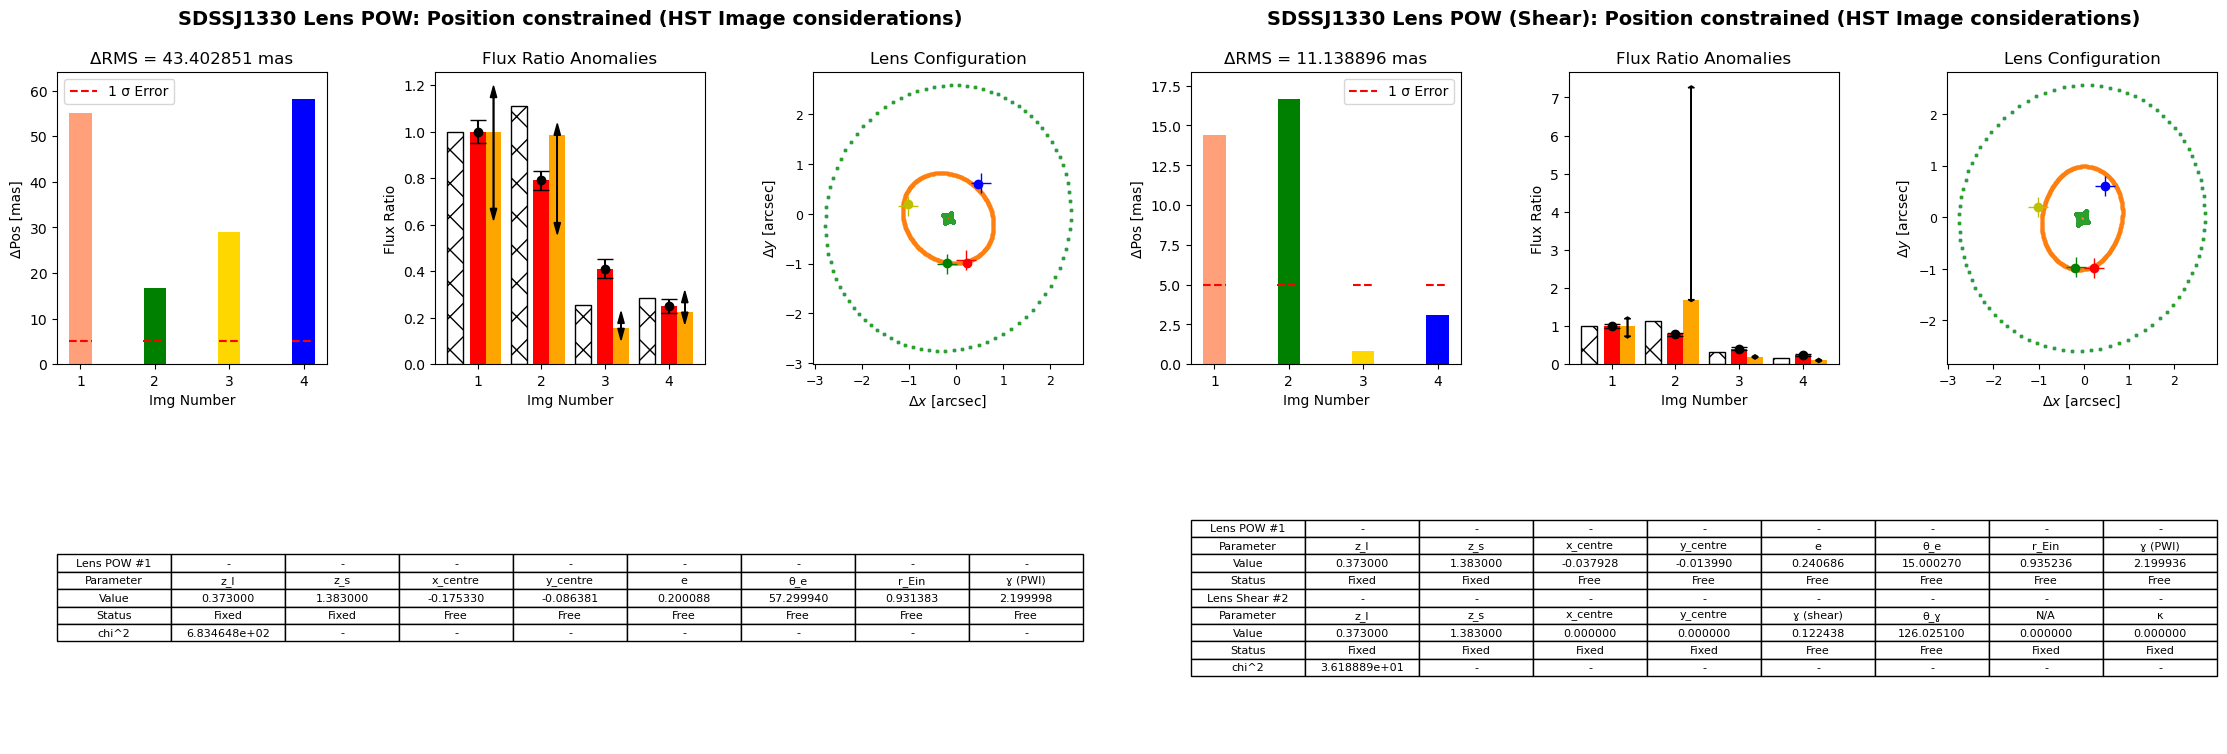

In [38]:
# Working Plotting Code that outputs lens anomaly results with all the necessary information as well as lens parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import math
import matplotlib.table as tbl
from matplotlib.patches import Rectangle

# Define groups of file paths

file_groups = [
    {
        "input_file": "SDSSJ1330/PPFC/Robs_point.dat",
        "output_file": "SDSSJ1330/PPC/outPP_N_point.dat",
        "fits_file": "SDSSJ1330/PPC/outPP_N_lens.fits",
        "Critical_Curve": "SDSSJ1330/PPC/outPP_N_crit.dat",
        "optresult_file": "SDSSJ1330/PPC/outPP_N_optresult.dat",
        "title": "SDSSJ1330 Lens POW: Position constrained (HST Image considerations)"
     },
    {
        "input_file": "SDSSJ1330/PPFC/Robs_point.dat",
        "output_file": "SDSSJ1330/PPC/outPPR_N_point.dat",
        "fits_file": "SDSSJ1330/PPC/outPPR_N_lens.fits",
        "Critical_Curve": "SDSSJ1330/PPC/outPPR_N_crit.dat",
        "optresult_file": "SDSSJ1330/PPC/outPPR_N_optresult.dat",
        "title": "SDSSJ1330 Lens POW (Shear): Position constrained (HST Image considerations)"
     },
]

n = 0.01

# Function to extract lens data from optresult file
def extract_lens_data(file_path):
    lens_data = []  # Will store tuples of (lens_type, data)
    chi2_value = None

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Warning: Could not find optresult file: {file_path}")
        return [], None

    # Step 1: Find the last occurrence of chi^2 in the file
    last_chi2_idx = None
    for idx, line in enumerate(lines):
        if line.strip().startswith("chi^2"):
            last_chi2_idx = idx

    if last_chi2_idx is None:
        print(f"Warning: No chi^2 section found in the file: {file_path}")
        return [], None

    # Step 2: Collect all lens profiles after the last chi^2
    for line in lines[last_chi2_idx:]:
        if line.strip().startswith("chi^2"):
            chi2_value = line.strip().split()[2]
        elif line.strip().startswith("lens   sie"):
            lens_data.append(('SIE', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pow"):
            lens_data.append(('POW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   anfw"):
            lens_data.append(('NFW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pert"):
            lens_data.append(('Shear', line.strip().split()[2:]))
        elif line.strip().startswith("lens   sers"):
            lens_data.append(('SERSIC', line.strip().split()[2:]))

    return lens_data, chi2_value

# Function to create parameter table
def create_parameter_table(lens_data, chi2_value):
    if not lens_data:
        return None
    
    # Prepare table data for all found profiles
    table_data = []
    for idx, (lens_type, data) in enumerate(lens_data, 1):
        data = [float(val) for val in data]
        data = [f"{val:.6e}" if abs(val) > 10000 else f"{val:.6f}" for val in data]

        if lens_type == "SIE":
            labels = ["z_l", "vel. disp.", "x_centre", "y_centre", "e", "θ_e", "r_core", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens SIE #{idx}"
        elif lens_type == "POW":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "e", "θ_e", "r_Ein", "ɣ (PWI)"]
            status = ["Fixed", "Fixed", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens POW #{idx}"
        elif lens_type == "NFW":
            labels = ["z_l", "M_DM", "x_centre", "y_centre", "e", "θ_e", "c", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Fixed"]
            header = f"Lens NFW #{idx}"
        elif lens_type == "Shear":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "ɣ (shear)", "θ_ɣ", "N/A", "κ"]
            status = ["Fixed", "Fixed", "Fixed", "Fixed", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens Shear #{idx}"
        elif lens_type == "SERSIC":
            labels = ["z_l", "M_BM", "x_centre", "y_centre", "e", "θ_e", "r_e", "n"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens SERSIC #{idx}"
        else:
            continue

        table_data.append([header, "-", "-", "-", "-", "-", "-", "-", "-"])
        table_data.append(["Parameter"] + labels)
        table_data.append(["Value"] + data)
        table_data.append(["Status"] + status)

    if chi2_value:
        table_data.append(["chi^2", chi2_value, "-", "-", "-", "-", "-", "-", "-"])

    return table_data

# Function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Function to read observed positions, flux ratio errors, and observed flux ratios
def read_observed_positions(input_file):
    observed_positions = []
    flux_ratio_errors = []
    observed_flux_ratios = []
    with open(input_file, 'r') as observed_file:
        observed_lines = observed_file.readlines()[1:]  # Skip the first line
        for line in observed_lines:
            columns = line.split()
            if len(columns) >= 5:
                x1 = float(columns[0])
                y1 = float(columns[1])
                flux_ratio = float(columns[2])  # Extract flux ratio from the third column
                observed_positions.append((x1, y1))
                flux_ratio_errors.append(float(columns[4]))  # Extract flux ratio error
                observed_flux_ratios.append(flux_ratio)
    return observed_positions, flux_ratio_errors, observed_flux_ratios

# Function to read predicted positions and magnifications
def read_predicted_positions(output_file):
    predicted_positions = []
    predicted_magnifications = []
    with open(output_file, 'r') as predicted_file:
        predicted_lines = predicted_file.readlines()[1:]  # Skip the first line
        for line in predicted_lines:
            if line.startswith("#"):
                continue  # Skip comment lines
            columns = line.split()
            if len(columns) >= 3:
                x2 = float(columns[0])
                y2 = float(columns[1])
                M2 = abs(float(columns[2]))  # Take the absolute value of the magnification
                predicted_positions.append((x2, y2))
                predicted_magnifications.append(M2)
    return predicted_positions, predicted_magnifications

# Function to pair predicted and observed positions
def pair_positions(observed_positions, predicted_positions, predicted_magnifications):
    paired_positions = []
    for observed_position in observed_positions:
        min_distance = float('inf')
        closest_index = None
        for i, predicted_position in enumerate(predicted_positions):
            distance = calculate_distance(*observed_position, *predicted_position)
            if distance < min_distance:
                min_distance = distance
                closest_index = i
        paired_positions.append((observed_position, predicted_positions[closest_index], predicted_magnifications[closest_index]))
    return paired_positions

Dependent_image = 0 ###### --------------- Select image to be dependent -------------------------------------------------------------------------------------------------------------

# Function to process the FITS file for observed values
def process_fits_file(fits_file, observed_positions, green_image_index= Dependent_image):
    with fits.open(fits_file) as hdul:
        Mag = hdul[0].data[6]
        
        image_size = Mag.shape
        center_x = image_size[1] // 2
        center_y = image_size[0] // 2
        pixel_coords = [(int((x + center_x * n) / n), int((y + center_y * n) / n)) for x, y in observed_positions]
        
        values = [Mag[y, x] for x, y in pixel_coords]
        abs_values = [1 / abs(value) for value in values]
        return abs_values, pixel_coords, image_size, Mag

# Function to calculate flux ratios and magnifications within error bounds
def calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag, green_image_index= Dependent_image):
    # Calculate flux ratios
    normalization_value = predicted_magnifications_ordered[green_image_index]
    predicted_flux_ratios = [magnification / normalization_value for magnification in predicted_magnifications_ordered]

    # Calculate flux ratios at the observed position 
    predicted_flux_ratios_observed = [abs_values[i] / abs_values[green_image_index] for i in range(len(abs_values))]
    
    # Calculate the circular range for each position
    error = 0.005
    value_ranges = []
    for x, y in pixel_coords:
        x_min = int(max(0, x - error / n))
        x_max = int(min(image_size[1] - 1, x + error / n))
        y_min = int(max(0, y - error / n))
        y_max = int(min(image_size[0] - 1, y + error / n))
        value_range = Mag[y_min : y_max + 1, x_min : x_max + 1]
        value_ranges.append(value_range)
    
    # Find the maximum and minimum values within each circular range
    max_values = [1 / np.min(np.abs(range_vals)) for range_vals in value_ranges]
    min_values = [1 / np.max(np.abs(range_vals)) for range_vals in value_ranges]
    
    # Automatically use the green_image_index position for normalization
    normalization_coord = pixel_coords[green_image_index]
    index = pixel_coords.index(normalization_coord)
    
    # Divide the base value by all other values
    divided_values = [abs_value / abs_values[index] for abs_value in abs_values]
    max_values = [max_value / abs_values[index] for max_value in max_values]
    min_values = [min_value / abs_values[index] for min_value in min_values]
    
    return predicted_flux_ratios, predicted_flux_ratios_observed, list(zip(min_values, max_values))

# Function to process a single group
def process_group(group_files):
    input_file = group_files["input_file"]
    output_file = group_files["output_file"]
    fits_file = group_files["fits_file"]
    Critical_Curve = group_files["Critical_Curve"]
    optresult_file = group_files["optresult_file"]  # Added this line
    
    # Read observed and predicted data
    observed_positions, flux_ratio_errors, observed_flux_ratios = read_observed_positions(input_file)
    predicted_positions, predicted_magnifications = read_predicted_positions(output_file)
    
    # Extract lens data for parameter table
    lens_data, chi2_value = extract_lens_data(optresult_file)
    table_data = create_parameter_table(lens_data, chi2_value)
    
    # Pair observed and predicted positions based on closeness
    paired_positions = []
    for i, observed_position in enumerate(observed_positions):
        min_distance = float('inf')
        closest_predicted = None
        for predicted_position in predicted_positions:
            distance = abs(observed_position[0] - predicted_position[0]) + abs(observed_position[1] - predicted_position[1])
            if distance < min_distance:
                min_distance = distance
                closest_predicted = predicted_position
        paired_positions.append((observed_position, closest_predicted))

    # Define pair names
    pair_names = ["Red Image", "Green Image", "Yellow Image", "Blue Image"]
        
    # Populate image_coordinates dictionary
    image_coordinates = {}
    for i, pair in enumerate(paired_positions):
        image_coordinates[pair_names[i]] = (*pair[0], *pair[1])

    # Calculate the distances and ΔRMS
    distances = []
    squared_distances = 0.0  # Initialize the sum of squared distances

    for image, coordinates in image_coordinates.items():
        x1, y1, x2, y2 = coordinates
        distance = calculate_distance(x1, y1, x2, y2)
        distances.append(distance)
        squared_distances += distance ** 2  # Sum the squared distances

    mean_squared_distances = squared_distances / len(image_coordinates)  # Calculate the mean of squared distances
    delta_rms = np.sqrt(mean_squared_distances)  # Calculate the root mean square

    # Convert distances to milliarc seconds for plotting
    distances_mas = [d * 1000 for d in distances]  # Convert from arcsec to milliarcsec
    delta_rms_mas = delta_rms * 1000  # Convert ΔRMS to milliarcsec

    # Pair positions
    paired_positions_detailed = pair_positions(observed_positions, predicted_positions, predicted_magnifications)

    # Order predicted positions and magnifications
    predicted_positions_ordered = [pair[1] for pair in paired_positions_detailed]
    predicted_magnifications_ordered = [pair[2] for pair in paired_positions_detailed]

    # Process FITS file
    abs_values, pixel_coords, image_size, Mag = process_fits_file(fits_file, observed_positions)

    # Calculate flux ratios and min/max magnifications
    predicted_flux_ratios, predicted_flux_ratios_observed, min_max_magnifications = calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag)

    # Read critical curve data
    caus = pd.read_csv(Critical_Curve, sep='\s+', header=None)
    caus = pd.DataFrame(caus)

    return {
        'distances_mas': distances_mas,
        'delta_rms_mas': delta_rms_mas,
        'observed_flux_ratios': observed_flux_ratios,
        'flux_ratio_errors': flux_ratio_errors,
        'predicted_flux_ratios': predicted_flux_ratios,
        'predicted_flux_ratios_observed': predicted_flux_ratios_observed,
        'min_max_magnifications': min_max_magnifications,
        'paired_positions_detailed': paired_positions_detailed,
        'pair_names': pair_names,
        'caus': caus,
        'table_data': table_data,  # Added this line
        'title': group_files["title"]
    }

# Function to plot a single group with parameter table
def plot_group(group_data, axs_group, colors, table_ax=None):
    distances_mas = group_data['distances_mas']
    delta_rms_mas = group_data['delta_rms_mas']
    observed_flux_ratios = group_data['observed_flux_ratios']
    flux_ratio_errors = group_data['flux_ratio_errors']
    predicted_flux_ratios = group_data['predicted_flux_ratios']
    predicted_flux_ratios_observed = group_data['predicted_flux_ratios_observed']
    min_max_magnifications = group_data['min_max_magnifications']
    paired_positions_detailed = group_data['paired_positions_detailed']
    pair_names = group_data['pair_names']
    caus = group_data['caus']
    table_data = group_data['table_data']
    
    # Plot 1: Positional offset
    x_positions = [1, 2, 3, 4]
    axs_group[0].bar(x_positions, distances_mas, color=colors, width=0.3)
    axs_group[0].axhline(y=5, xmin=0.045, xmax=0.13, color='r', linestyle='dashed', label="1 σ Error")
    axs_group[0].axhline(y=5, xmin=0.32, xmax=0.4, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.6, xmax=0.68, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.87, xmax=0.95, color='r', linestyle='dashed')
    axs_group[0].set_xlabel("Img Number")
    axs_group[0].set_ylabel("ΔPos [mas]")
    axs_group[0].set_title(f"ΔRMS = {delta_rms_mas:.6f} mas")

    # Ensure y-axis always starts from 0
    max_distance_mas = max(distances_mas) if distances_mas else 10
    y_max = max(max_distance_mas * 1.1, 15)
    axs_group[0].set_ylim(0, y_max)

    axs_group[0].set_xticks(x_positions)
    axs_group[0].set_xticklabels([1, 2, 3, 4])
    axs_group[0].legend()

    # Plot 2: Flux ratios
    barWidth = 0.25
    br1 = np.arange(len(observed_flux_ratios))
    br2 = [x + barWidth for x in br1]
    br3 = [x + 2 * barWidth for x in br1]
    br1, br2 = br2, br1

    axs_group[1].bar(br1, observed_flux_ratios, color='red', width=barWidth, label='μ_obs/μ_ref')
    axs_group[1].bar(br2-0.1, predicted_flux_ratios, color='white', edgecolor='black', hatch='\\/', width=barWidth, label='μ_pred/μ_ref')
    axs_group[1].bar(br3, predicted_flux_ratios_observed, color='orange', width=barWidth, label='µ_pred/μ_ref (obs pos)')
    
    axs_group[1].set_xlabel('Img Number', fontsize=10)
    axs_group[1].set_ylabel('Flux Ratio', fontsize=10)
    axs_group[1].set_xticks([r + barWidth for r in range(len(observed_flux_ratios))])
    axs_group[1].set_xticklabels([1, 2, 3, 4], fontsize=10)
    axs_group[1].set_title("Flux Ratio Anomalies", fontsize=12)

    # Add error bars for observed flux ratios
    axs_group[1].errorbar(br1, observed_flux_ratios, yerr=flux_ratio_errors, fmt='o', color='black', capsize=6, label='1 σ Error')

    # Creating magnification arrows with correct min and max values
    for x, (min_val, max_val) in zip(br3, min_max_magnifications):
        arrow_length = max_val - min_val
        # Draw arrow from min_val to max_val
        axs_group[1].arrow(x, min_val, 0, arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')
        axs_group[1].arrow(x, max_val, 0, -arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')

    # Plot 3: Lens configuration
    x1, y1 = 0, 0

    def center_corr_arcsec(x, y):
        x0, y0 = x1, y1
        x_prime = x + x0
        y_prime = y + y0
        return x_prime, y_prime

    # Convert critical curves and caustics to arcseconds
    xs1, ys1 = center_corr_arcsec(caus[2], caus[3])
    xs2, ys2 = center_corr_arcsec(caus[6], caus[7])
    xc1, yc1 = center_corr_arcsec(caus[0], caus[1])
    xc2, yc2 = center_corr_arcsec(caus[4], caus[5])

    axs_group[2].scatter(xs1, ys1, marker=',', s=1, label='Caustics')
    axs_group[2].scatter(xc1, yc1, marker=',', s=1, label='Crit Curve')
    axs_group[2].scatter(xs2, ys2, marker=',', s=1, label='Caustics')
    axs_group[2].set_xlabel('Δ$x$ [arcsec]', fontsize=10)
    axs_group[2].set_ylabel('Δ$y$ [arcsec]', fontsize=10)
    axs_group[2].set_title("Lens Configuration", fontsize=12)

    # Plot predicted and observed positions
    for i in range(len(paired_positions_detailed)):
        pair_name = pair_names[i]
        observed_position = paired_positions_detailed[i][0]
        predicted_position = paired_positions_detailed[i][1]
        
        if pair_name == "Red Image":
            pred_color = 'r+'
            obs_color = 'r'
        elif pair_name == "Green Image":
            pred_color = 'g+'
            obs_color = 'g'
        elif pair_name == "Yellow Image":
            pred_color = 'y+'
            obs_color = 'y'
        elif pair_name == "Blue Image":
            pred_color = 'b+'
            obs_color = 'b'
        
        axs_group[2].plot(predicted_position[0], predicted_position[1], pred_color, markersize=15)
        axs_group[2].plot(observed_position[0] - x1, observed_position[1] - y1, obs_color, marker='o')

    axs_group[2].tick_params(axis='both', which='major', labelsize=9)
    
    # Add parameter table if table_ax is provided and table_data exists
    if table_ax is not None and table_data:
        table_ax.axis('off')
        table = tbl.table(table_ax, cellText=table_data, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.0)

# Main execution
num_groups = len(file_groups)
colors = ['lightsalmon', 'green', 'gold', 'blue']

# Process all groups
group_results = []
for group_files in file_groups:
    group_data = process_group(group_files)
    group_results.append(group_data)

# Handle plotting based on number of groups
if num_groups == 1:
    # Special case for single group - use original layout with table
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplot layout: 3 plots on top, table on bottom
    axs = [plt.subplot2grid((2, 3), (0, i)) for i in range(3)]
    table_ax = plt.subplot2grid((2, 3), (1, 0), colspan=3)
    
    # Plot the single group
    plot_group(group_results[0], axs, colors, table_ax)
    
    # Set the title to the group's specific title
    plt.suptitle(group_results[0]['title'], fontsize=16)
    plt.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.85, wspace=0.3, hspace=0.1)

else:
    # Multi-group layout: left, right, bottom-left, bottom-right pattern with tables
    rows = math.ceil(num_groups / 2) * 2  # Double the rows to accommodate tables
    cols = 2
    
    fig = plt.figure(figsize=(24, 8 * math.ceil(num_groups / 2)))
    
    for group_idx, group_data in enumerate(group_results):
        # Calculate position: left-right pattern, then move to next row
        row = (group_idx // 2) * 2  # Every two groups take 2 rows
        col = group_idx % 2
        
        # Create 3 subplots for this group using subplot2grid
        axs_group = []
        for plot_idx in range(3):
            ax = plt.subplot2grid((rows, 6), (row, col*3 + plot_idx))
            axs_group.append(ax)
        
        # Create table subplot below the plots
        table_ax = plt.subplot2grid((rows, 6), (row + 1, col*3), colspan=3)
        
        # Plot this group
        plot_group(group_data, axs_group, colors, table_ax)
        
        # Add group title above each group
        middle_ax = axs_group[1]  # Middle subplot of the 3-subplot group
        title_x = 0.5
        title_y = 1.15
        
        middle_ax.text(title_x, title_y, group_data['title'], 
                      ha='center', va='bottom', fontsize=14, weight='bold',
                      transform=middle_ax.transAxes)
    
    # Calculate hspace based on number of row pairs to maintain consistent spacing
    num_row_pairs = math.ceil(num_groups / 2)
    # Use a scaling factor that decreases as more rows are added
    hspace_value = 0.5 / num_row_pairs if num_row_pairs > 1 else 0.3
    
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.96, top=0.92, wspace=0.4, hspace=hspace_value)

# Print results for all groups
for group_idx, group_data in enumerate(group_results):
    print(f"\n=== GROUP {group_idx + 1}: {group_data['title']} ===")
    print("Observed Flux Ratios:", group_data['observed_flux_ratios'])
    print("Predicted Flux Ratios (Obs Pos):", group_data['predicted_flux_ratios_observed'])
    print("Predicted Flux Ratios (Pred Pos):", group_data['predicted_flux_ratios'])

# Save the plot
if num_groups == 1:
    # Use the group's title for filename when single group
    base_filename = group_results[0]['title'].replace(' ', '_').replace(':', '').replace('(', '').replace(')', '')
    file_name = f'{base_filename}.pdf'
else:
    file_name = 'SDSSJ1330/Group_Plot_SDSSJ1330_POW_N.pdf'

if os.path.isfile(file_name):
    base_name, extension = os.path.splitext(file_name)
    counter = 1
    while os.path.isfile(f"{base_name} ({counter}){extension}"):
        counter += 1
    file_name = f"{base_name} ({counter}){extension}"

plt.savefig(file_name)
#plt.show()


=== GROUP 1: WGDJ0405 Lens POW: Position constrained (HST Image considerations) ===
Observed Flux Ratios: [0.8, 0.52, 1.0, 0.936]
Predicted Flux Ratios (Obs Pos): [0.7368535855427047, 0.5796439307240405, 1.0, 1.0193156837292923]
Predicted Flux Ratios (Pred Pos): [0.8967505241090147, 0.6652565638414695, 1.0, 0.9516571827892583]

=== GROUP 2: WGDJ0405 Lens POW (Shear): Position constrained (HST Image considerations) ===
Observed Flux Ratios: [0.8, 0.52, 1.0, 0.936]
Predicted Flux Ratios (Obs Pos): [0.7520851347580134, 0.523123965426013, 1.0, 0.8600642421235606]
Predicted Flux Ratios (Pred Pos): [0.8478623104342874, 0.640790111999325, 1.0, 0.9630887346818248]


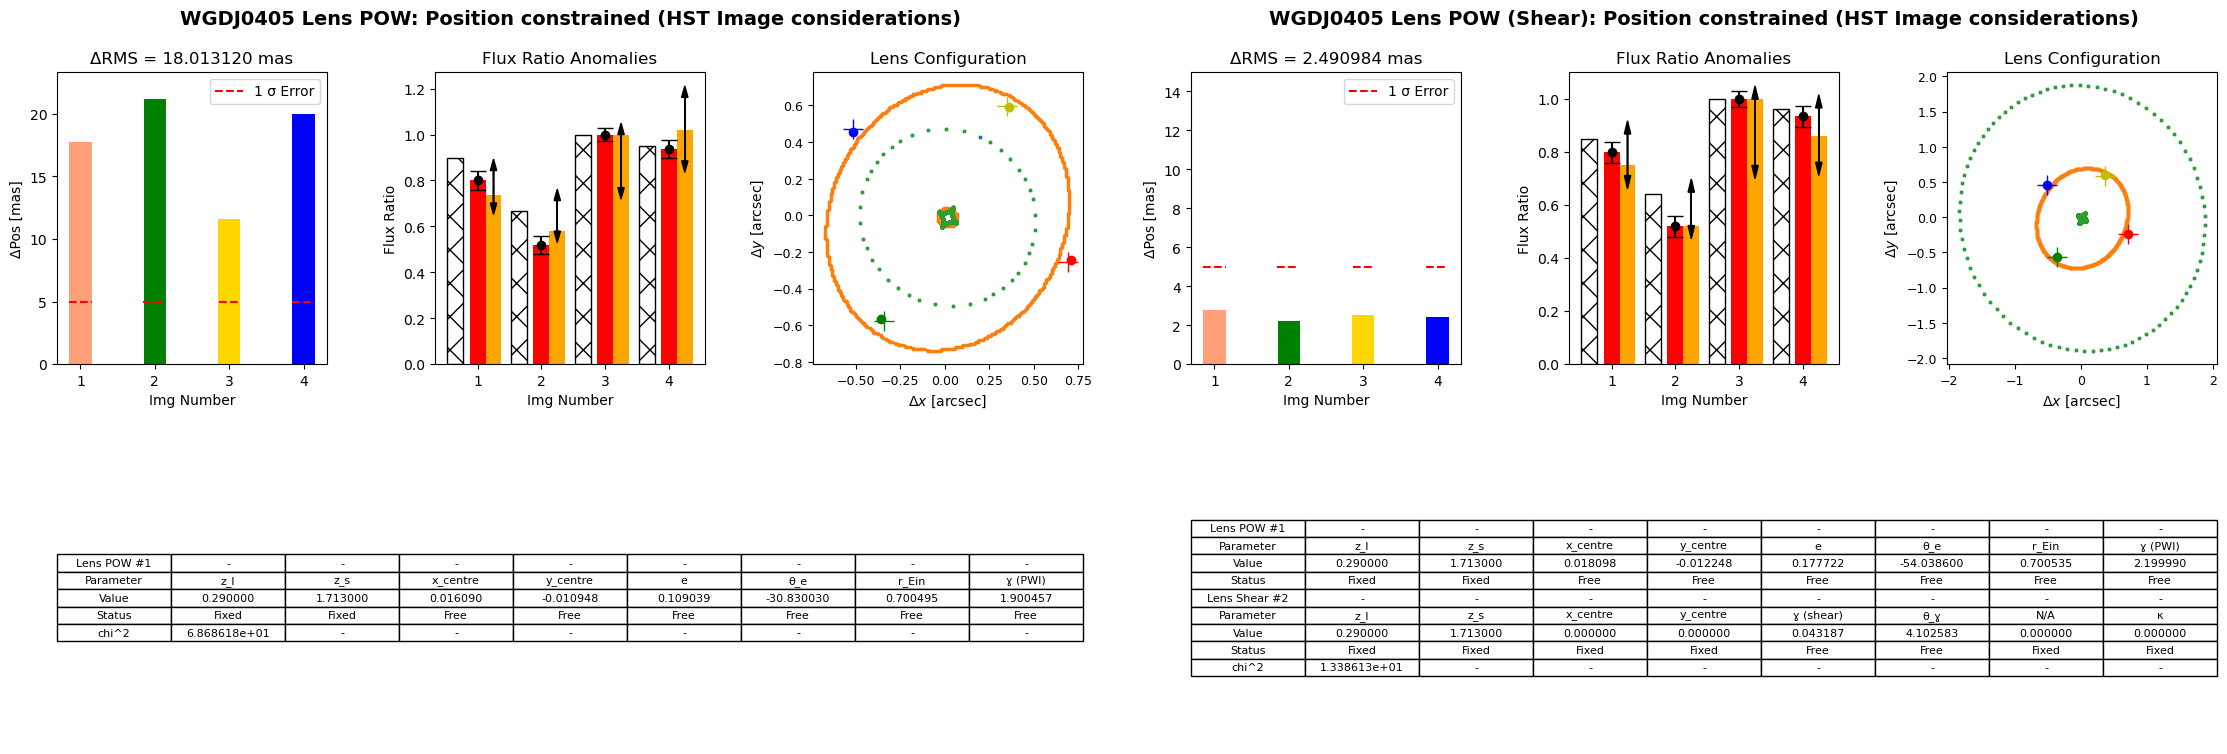

In [2]:
# Working Plotting Code that outputs lens anomaly results with all the necessary information as well as lens parameters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os
import math
import matplotlib.table as tbl
from matplotlib.patches import Rectangle

# Define groups of file paths

file_groups = [
    {
        "input_file": "WGDJ0405/PPFC/Eobs_point.dat",
        "output_file": "WGDJ0405/PPC/outPP_N_point.dat",
        "fits_file": "WGDJ0405/PPC/outPP_N_lens.fits",
        "Critical_Curve": "WGDJ0405/PPC/outPP_N_crit.dat",
        "optresult_file": "WGDJ0405/PPC/outPP_N_optresult.dat",
        "title": "WGDJ0405 Lens POW: Position constrained (HST Image considerations)"
     },
    {
        "input_file": "WGDJ0405/PPFC/Eobs_point.dat",
        "output_file": "WGDJ0405/PPC/outPPR_N_point.dat",
        "fits_file": "WGDJ0405/PPC/outPPR_N_lens.fits",
        "Critical_Curve": "WGDJ0405/PPC/outPPR_N_crit.dat",
        "optresult_file": "WGDJ0405/PPC/outPPR_N_optresult.dat",
        "title": "WGDJ0405 Lens POW (Shear): Position constrained (HST Image considerations)"
     },
]

n = 0.01

# Function to extract lens data from optresult file
def extract_lens_data(file_path):
    lens_data = []  # Will store tuples of (lens_type, data)
    chi2_value = None

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
    except FileNotFoundError:
        print(f"Warning: Could not find optresult file: {file_path}")
        return [], None

    # Step 1: Find the last occurrence of chi^2 in the file
    last_chi2_idx = None
    for idx, line in enumerate(lines):
        if line.strip().startswith("chi^2"):
            last_chi2_idx = idx

    if last_chi2_idx is None:
        print(f"Warning: No chi^2 section found in the file: {file_path}")
        return [], None

    # Step 2: Collect all lens profiles after the last chi^2
    for line in lines[last_chi2_idx:]:
        if line.strip().startswith("chi^2"):
            chi2_value = line.strip().split()[2]
        elif line.strip().startswith("lens   sie"):
            lens_data.append(('SIE', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pow"):
            lens_data.append(('POW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   anfw"):
            lens_data.append(('NFW', line.strip().split()[2:]))
        elif line.strip().startswith("lens   pert"):
            lens_data.append(('Shear', line.strip().split()[2:]))
        elif line.strip().startswith("lens   sers"):
            lens_data.append(('SERSIC', line.strip().split()[2:]))

    return lens_data, chi2_value

# Function to create parameter table
def create_parameter_table(lens_data, chi2_value):
    if not lens_data:
        return None
    
    # Prepare table data for all found profiles
    table_data = []
    for idx, (lens_type, data) in enumerate(lens_data, 1):
        data = [float(val) for val in data]
        data = [f"{val:.6e}" if abs(val) > 10000 else f"{val:.6f}" for val in data]

        if lens_type == "SIE":
            labels = ["z_l", "vel. disp.", "x_centre", "y_centre", "e", "θ_e", "r_core", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens SIE #{idx}"
        elif lens_type == "POW":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "e", "θ_e", "r_Ein", "ɣ (PWI)"]
            status = ["Fixed", "Fixed", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens POW #{idx}"
        elif lens_type == "NFW":
            labels = ["z_l", "M_DM", "x_centre", "y_centre", "e", "θ_e", "c", "N/A"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Fixed"]
            header = f"Lens NFW #{idx}"
        elif lens_type == "Shear":
            labels = ["z_l", "z_s", "x_centre", "y_centre", "ɣ (shear)", "θ_ɣ", "N/A", "κ"]
            status = ["Fixed", "Fixed", "Fixed", "Fixed", "Free", "Free", "Fixed", "Fixed"]
            header = f"Lens Shear #{idx}"
        elif lens_type == "SERSIC":
            labels = ["z_l", "M_BM", "x_centre", "y_centre", "e", "θ_e", "r_e", "n"]
            status = ["Fixed", "Free", "Free", "Free", "Free", "Free", "Free", "Free"]
            header = f"Lens SERSIC #{idx}"
        else:
            continue

        table_data.append([header, "-", "-", "-", "-", "-", "-", "-", "-"])
        table_data.append(["Parameter"] + labels)
        table_data.append(["Value"] + data)
        table_data.append(["Status"] + status)

    if chi2_value:
        table_data.append(["chi^2", chi2_value, "-", "-", "-", "-", "-", "-", "-"])

    return table_data

# Function to calculate distance
def calculate_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

# Function to read observed positions, flux ratio errors, and observed flux ratios
def read_observed_positions(input_file):
    observed_positions = []
    flux_ratio_errors = []
    observed_flux_ratios = []
    with open(input_file, 'r') as observed_file:
        observed_lines = observed_file.readlines()[1:]  # Skip the first line
        for line in observed_lines:
            columns = line.split()
            if len(columns) >= 5:
                x1 = float(columns[0])
                y1 = float(columns[1])
                flux_ratio = float(columns[2])  # Extract flux ratio from the third column
                observed_positions.append((x1, y1))
                flux_ratio_errors.append(float(columns[4]))  # Extract flux ratio error
                observed_flux_ratios.append(flux_ratio)
    return observed_positions, flux_ratio_errors, observed_flux_ratios

# Function to read predicted positions and magnifications
def read_predicted_positions(output_file):
    predicted_positions = []
    predicted_magnifications = []
    with open(output_file, 'r') as predicted_file:
        predicted_lines = predicted_file.readlines()[1:]  # Skip the first line
        for line in predicted_lines:
            if line.startswith("#"):
                continue  # Skip comment lines
            columns = line.split()
            if len(columns) >= 3:
                x2 = float(columns[0])
                y2 = float(columns[1])
                M2 = abs(float(columns[2]))  # Take the absolute value of the magnification
                predicted_positions.append((x2, y2))
                predicted_magnifications.append(M2)
    return predicted_positions, predicted_magnifications

# Function to pair predicted and observed positions
def pair_positions(observed_positions, predicted_positions, predicted_magnifications):
    paired_positions = []
    for observed_position in observed_positions:
        min_distance = float('inf')
        closest_index = None
        for i, predicted_position in enumerate(predicted_positions):
            distance = calculate_distance(*observed_position, *predicted_position)
            if distance < min_distance:
                min_distance = distance
                closest_index = i
        paired_positions.append((observed_position, predicted_positions[closest_index], predicted_magnifications[closest_index]))
    return paired_positions

Dependent_image = 2 ###### --------------- Select image to be dependent -------------------------------------------------------------------------------------------------------------

# Function to process the FITS file for observed values
def process_fits_file(fits_file, observed_positions, green_image_index= Dependent_image):
    with fits.open(fits_file) as hdul:
        Mag = hdul[0].data[6]
        
        image_size = Mag.shape
        center_x = image_size[1] // 2
        center_y = image_size[0] // 2
        pixel_coords = [(int((x + center_x * n) / n), int((y + center_y * n) / n)) for x, y in observed_positions]
        
        values = [Mag[y, x] for x, y in pixel_coords]
        abs_values = [1 / abs(value) for value in values]
        return abs_values, pixel_coords, image_size, Mag

# Function to calculate flux ratios and magnifications within error bounds
def calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag, green_image_index= Dependent_image):
    # Calculate flux ratios
    normalization_value = predicted_magnifications_ordered[green_image_index]
    predicted_flux_ratios = [magnification / normalization_value for magnification in predicted_magnifications_ordered]

    # Calculate flux ratios at the observed position 
    predicted_flux_ratios_observed = [abs_values[i] / abs_values[green_image_index] for i in range(len(abs_values))]
    
    # Calculate the circular range for each position
    error = 0.005
    value_ranges = []
    for x, y in pixel_coords:
        x_min = int(max(0, x - error / n))
        x_max = int(min(image_size[1] - 1, x + error / n))
        y_min = int(max(0, y - error / n))
        y_max = int(min(image_size[0] - 1, y + error / n))
        value_range = Mag[y_min : y_max + 1, x_min : x_max + 1]
        value_ranges.append(value_range)
    
    # Find the maximum and minimum values within each circular range
    max_values = [1 / np.min(np.abs(range_vals)) for range_vals in value_ranges]
    min_values = [1 / np.max(np.abs(range_vals)) for range_vals in value_ranges]
    
    # Automatically use the green_image_index position for normalization
    normalization_coord = pixel_coords[green_image_index]
    index = pixel_coords.index(normalization_coord)
    
    # Divide the base value by all other values
    divided_values = [abs_value / abs_values[index] for abs_value in abs_values]
    max_values = [max_value / abs_values[index] for max_value in max_values]
    min_values = [min_value / abs_values[index] for min_value in min_values]
    
    return predicted_flux_ratios, predicted_flux_ratios_observed, list(zip(min_values, max_values))

# Function to process a single group
def process_group(group_files):
    input_file = group_files["input_file"]
    output_file = group_files["output_file"]
    fits_file = group_files["fits_file"]
    Critical_Curve = group_files["Critical_Curve"]
    optresult_file = group_files["optresult_file"]  # Added this line
    
    # Read observed and predicted data
    observed_positions, flux_ratio_errors, observed_flux_ratios = read_observed_positions(input_file)
    predicted_positions, predicted_magnifications = read_predicted_positions(output_file)
    
    # Extract lens data for parameter table
    lens_data, chi2_value = extract_lens_data(optresult_file)
    table_data = create_parameter_table(lens_data, chi2_value)
    
    # Pair observed and predicted positions based on closeness
    paired_positions = []
    for i, observed_position in enumerate(observed_positions):
        min_distance = float('inf')
        closest_predicted = None
        for predicted_position in predicted_positions:
            distance = abs(observed_position[0] - predicted_position[0]) + abs(observed_position[1] - predicted_position[1])
            if distance < min_distance:
                min_distance = distance
                closest_predicted = predicted_position
        paired_positions.append((observed_position, closest_predicted))

    # Define pair names
    pair_names = ["Red Image", "Green Image", "Yellow Image", "Blue Image"]
        
    # Populate image_coordinates dictionary
    image_coordinates = {}
    for i, pair in enumerate(paired_positions):
        image_coordinates[pair_names[i]] = (*pair[0], *pair[1])

    # Calculate the distances and ΔRMS
    distances = []
    squared_distances = 0.0  # Initialize the sum of squared distances

    for image, coordinates in image_coordinates.items():
        x1, y1, x2, y2 = coordinates
        distance = calculate_distance(x1, y1, x2, y2)
        distances.append(distance)
        squared_distances += distance ** 2  # Sum the squared distances

    mean_squared_distances = squared_distances / len(image_coordinates)  # Calculate the mean of squared distances
    delta_rms = np.sqrt(mean_squared_distances)  # Calculate the root mean square

    # Convert distances to milliarc seconds for plotting
    distances_mas = [d * 1000 for d in distances]  # Convert from arcsec to milliarcsec
    delta_rms_mas = delta_rms * 1000  # Convert ΔRMS to milliarcsec

    # Pair positions
    paired_positions_detailed = pair_positions(observed_positions, predicted_positions, predicted_magnifications)

    # Order predicted positions and magnifications
    predicted_positions_ordered = [pair[1] for pair in paired_positions_detailed]
    predicted_magnifications_ordered = [pair[2] for pair in paired_positions_detailed]

    # Process FITS file
    abs_values, pixel_coords, image_size, Mag = process_fits_file(fits_file, observed_positions)

    # Calculate flux ratios and min/max magnifications
    predicted_flux_ratios, predicted_flux_ratios_observed, min_max_magnifications = calculate_flux_ratios_and_magnifications(predicted_magnifications_ordered, abs_values, pixel_coords, image_size, Mag)

    # Read critical curve data
    caus = pd.read_csv(Critical_Curve, sep='\s+', header=None)
    caus = pd.DataFrame(caus)

    return {
        'distances_mas': distances_mas,
        'delta_rms_mas': delta_rms_mas,
        'observed_flux_ratios': observed_flux_ratios,
        'flux_ratio_errors': flux_ratio_errors,
        'predicted_flux_ratios': predicted_flux_ratios,
        'predicted_flux_ratios_observed': predicted_flux_ratios_observed,
        'min_max_magnifications': min_max_magnifications,
        'paired_positions_detailed': paired_positions_detailed,
        'pair_names': pair_names,
        'caus': caus,
        'table_data': table_data,  # Added this line
        'title': group_files["title"]
    }

# Function to plot a single group with parameter table
def plot_group(group_data, axs_group, colors, table_ax=None):
    distances_mas = group_data['distances_mas']
    delta_rms_mas = group_data['delta_rms_mas']
    observed_flux_ratios = group_data['observed_flux_ratios']
    flux_ratio_errors = group_data['flux_ratio_errors']
    predicted_flux_ratios = group_data['predicted_flux_ratios']
    predicted_flux_ratios_observed = group_data['predicted_flux_ratios_observed']
    min_max_magnifications = group_data['min_max_magnifications']
    paired_positions_detailed = group_data['paired_positions_detailed']
    pair_names = group_data['pair_names']
    caus = group_data['caus']
    table_data = group_data['table_data']
    
    # Plot 1: Positional offset
    x_positions = [1, 2, 3, 4]
    axs_group[0].bar(x_positions, distances_mas, color=colors, width=0.3)
    axs_group[0].axhline(y=5, xmin=0.045, xmax=0.13, color='r', linestyle='dashed', label="1 σ Error")
    axs_group[0].axhline(y=5, xmin=0.32, xmax=0.4, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.6, xmax=0.68, color='r', linestyle='dashed')
    axs_group[0].axhline(y=5, xmin=0.87, xmax=0.95, color='r', linestyle='dashed')
    axs_group[0].set_xlabel("Img Number")
    axs_group[0].set_ylabel("ΔPos [mas]")
    axs_group[0].set_title(f"ΔRMS = {delta_rms_mas:.6f} mas")

    # Ensure y-axis always starts from 0
    max_distance_mas = max(distances_mas) if distances_mas else 10
    y_max = max(max_distance_mas * 1.1, 15)
    axs_group[0].set_ylim(0, y_max)

    axs_group[0].set_xticks(x_positions)
    axs_group[0].set_xticklabels([1, 2, 3, 4])
    axs_group[0].legend()

    # Plot 2: Flux ratios
    barWidth = 0.25
    br1 = np.arange(len(observed_flux_ratios))
    br2 = [x + barWidth for x in br1]
    br3 = [x + 2 * barWidth for x in br1]
    br1, br2 = br2, br1

    axs_group[1].bar(br1, observed_flux_ratios, color='red', width=barWidth, label='μ_obs/μ_ref')
    axs_group[1].bar(br2-0.1, predicted_flux_ratios, color='white', edgecolor='black', hatch='\\/', width=barWidth, label='μ_pred/μ_ref')
    axs_group[1].bar(br3, predicted_flux_ratios_observed, color='orange', width=barWidth, label='µ_pred/μ_ref (obs pos)')
    
    axs_group[1].set_xlabel('Img Number', fontsize=10)
    axs_group[1].set_ylabel('Flux Ratio', fontsize=10)
    axs_group[1].set_xticks([r + barWidth for r in range(len(observed_flux_ratios))])
    axs_group[1].set_xticklabels([1, 2, 3, 4], fontsize=10)
    axs_group[1].set_title("Flux Ratio Anomalies", fontsize=12)

    # Add error bars for observed flux ratios
    axs_group[1].errorbar(br1, observed_flux_ratios, yerr=flux_ratio_errors, fmt='o', color='black', capsize=6, label='1 σ Error')

    # Creating magnification arrows with correct min and max values
    for x, (min_val, max_val) in zip(br3, min_max_magnifications):
        arrow_length = max_val - min_val
        # Draw arrow from min_val to max_val
        axs_group[1].arrow(x, min_val, 0, arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')
        axs_group[1].arrow(x, max_val, 0, -arrow_length, head_width=0.1, head_length=0.05, fc='black', ec='black')

    # Plot 3: Lens configuration
    x1, y1 = 0, 0

    def center_corr_arcsec(x, y):
        x0, y0 = x1, y1
        x_prime = x + x0
        y_prime = y + y0
        return x_prime, y_prime

    # Convert critical curves and caustics to arcseconds
    xs1, ys1 = center_corr_arcsec(caus[2], caus[3])
    xs2, ys2 = center_corr_arcsec(caus[6], caus[7])
    xc1, yc1 = center_corr_arcsec(caus[0], caus[1])
    xc2, yc2 = center_corr_arcsec(caus[4], caus[5])

    axs_group[2].scatter(xs1, ys1, marker=',', s=1, label='Caustics')
    axs_group[2].scatter(xc1, yc1, marker=',', s=1, label='Crit Curve')
    axs_group[2].scatter(xs2, ys2, marker=',', s=1, label='Caustics')
    axs_group[2].set_xlabel('Δ$x$ [arcsec]', fontsize=10)
    axs_group[2].set_ylabel('Δ$y$ [arcsec]', fontsize=10)
    axs_group[2].set_title("Lens Configuration", fontsize=12)

    # Plot predicted and observed positions
    for i in range(len(paired_positions_detailed)):
        pair_name = pair_names[i]
        observed_position = paired_positions_detailed[i][0]
        predicted_position = paired_positions_detailed[i][1]
        
        if pair_name == "Red Image":
            pred_color = 'r+'
            obs_color = 'r'
        elif pair_name == "Green Image":
            pred_color = 'g+'
            obs_color = 'g'
        elif pair_name == "Yellow Image":
            pred_color = 'y+'
            obs_color = 'y'
        elif pair_name == "Blue Image":
            pred_color = 'b+'
            obs_color = 'b'
        
        axs_group[2].plot(predicted_position[0], predicted_position[1], pred_color, markersize=15)
        axs_group[2].plot(observed_position[0] - x1, observed_position[1] - y1, obs_color, marker='o')

    axs_group[2].tick_params(axis='both', which='major', labelsize=9)
    
    # Add parameter table if table_ax is provided and table_data exists
    if table_ax is not None and table_data:
        table_ax.axis('off')
        table = tbl.table(table_ax, cellText=table_data, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.0, 1.0)

# Main execution
num_groups = len(file_groups)
colors = ['lightsalmon', 'green', 'gold', 'blue']

# Process all groups
group_results = []
for group_files in file_groups:
    group_data = process_group(group_files)
    group_results.append(group_data)

# Handle plotting based on number of groups
if num_groups == 1:
    # Special case for single group - use original layout with table
    fig = plt.figure(figsize=(15, 10))
    
    # Create subplot layout: 3 plots on top, table on bottom
    axs = [plt.subplot2grid((2, 3), (0, i)) for i in range(3)]
    table_ax = plt.subplot2grid((2, 3), (1, 0), colspan=3)
    
    # Plot the single group
    plot_group(group_results[0], axs, colors, table_ax)
    
    # Set the title to the group's specific title
    plt.suptitle(group_results[0]['title'], fontsize=16)
    plt.subplots_adjust(left=0.08, bottom=0.15, right=0.95, top=0.85, wspace=0.3, hspace=0.1)

else:
    # Multi-group layout: left, right, bottom-left, bottom-right pattern with tables
    rows = math.ceil(num_groups / 2) * 2  # Double the rows to accommodate tables
    cols = 2
    
    fig = plt.figure(figsize=(24, 8 * math.ceil(num_groups / 2)))
    
    for group_idx, group_data in enumerate(group_results):
        # Calculate position: left-right pattern, then move to next row
        row = (group_idx // 2) * 2  # Every two groups take 2 rows
        col = group_idx % 2
        
        # Create 3 subplots for this group using subplot2grid
        axs_group = []
        for plot_idx in range(3):
            ax = plt.subplot2grid((rows, 6), (row, col*3 + plot_idx))
            axs_group.append(ax)
        
        # Create table subplot below the plots
        table_ax = plt.subplot2grid((rows, 6), (row + 1, col*3), colspan=3)
        
        # Plot this group
        plot_group(group_data, axs_group, colors, table_ax)
        
        # Add group title above each group
        middle_ax = axs_group[1]  # Middle subplot of the 3-subplot group
        title_x = 0.5
        title_y = 1.15
        
        middle_ax.text(title_x, title_y, group_data['title'], 
                      ha='center', va='bottom', fontsize=14, weight='bold',
                      transform=middle_ax.transAxes)
    
    # Calculate hspace based on number of row pairs to maintain consistent spacing
    num_row_pairs = math.ceil(num_groups / 2)
    # Use a scaling factor that decreases as more rows are added
    hspace_value = 0.5 / num_row_pairs if num_row_pairs > 1 else 0.3
    
    plt.subplots_adjust(left=0.06, bottom=0.08, right=0.96, top=0.92, wspace=0.4, hspace=hspace_value)

# Print results for all groups
for group_idx, group_data in enumerate(group_results):
    print(f"\n=== GROUP {group_idx + 1}: {group_data['title']} ===")
    print("Observed Flux Ratios:", group_data['observed_flux_ratios'])
    print("Predicted Flux Ratios (Obs Pos):", group_data['predicted_flux_ratios_observed'])
    print("Predicted Flux Ratios (Pred Pos):", group_data['predicted_flux_ratios'])

# Save the plot
if num_groups == 1:
    # Use the group's title for filename when single group
    base_filename = group_results[0]['title'].replace(' ', '_').replace(':', '').replace('(', '').replace(')', '')
    file_name = f'{base_filename}.pdf'
else:
    file_name = 'WGDJ0405/Group_Plot_WGDJ0405_POW_N.pdf'

if os.path.isfile(file_name):
    base_name, extension = os.path.splitext(file_name)
    counter = 1
    while os.path.isfile(f"{base_name} ({counter}){extension}"):
        counter += 1
    file_name = f"{base_name} ({counter}){extension}"

plt.savefig(file_name)
#plt.show()